In [1]:
import os
import random
import seaborn as sns
import scipy
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
import torch.distributions as dt
import torchvision.datasets as dset


In [135]:
datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt"]
models=['C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variance_GAN_higher_lr_result.model','C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variance_NVP.model']

In [2]:
class Generator(nn.Module):
    def __init__(self, generator_net, latent_dim):
        super(Generator, self).__init__()
        
        # We need to init the generator neural net.
        self.generator_net = generator_net
        # We also need to know the size of the latents.
        self.latent_dim = latent_dim

    def generate(self, z):
        # Generating for given z is equivalent to applying the neural net.
        return self.generator_net(z)

    def sample(self, batch_size=100):
        # For sampling, we need to sample first latents.
        z = torch.randn(batch_size, self.latent_dim).to(device)
        return self.generate(z)

    def forward(self, z=None):
        if z is None:
            return self.sample()
        else:
            return self.generate(z)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_net):
        super(Discriminator, self).__init__()
        # We need to init the discriminator neural net.
        self.discriminator_net = discriminator_net

    def forward(self, x):
        # The forward pass is just about applying the neural net.
        return self.discriminator_net(x)

In [4]:
class GAN(nn.Module):
    def __init__(self, generator, discriminator, EPS=1.e-5):
        super(GAN, self).__init__()
        
        # To put everything together, we need the generator and 
        # the discriminator. NOTE: Both are intanced of classes!
        self.generator = generator
        self.discriminator = discriminator
        
        # For numerical issue, we introduce a small epsilon.
        self.EPS = EPS

    def forward(self, x_real, reduction='avg', mode='discriminator'):
        # The forward pass calculates the adversarial loss.
        # More specifically, either its part for the generator or
        #  the part for the discriminator.
        if mode == 'generator':
            # For the generator, we first sample FAKE data.
            x_fake_gen = self.generator.sample(x_real.shape[0])
            #print("Generator Fake samples shape: " + str(x_fake_gen.shape))
            #print("Generator Real samples shape: " + str(x_real.shape))
            # Then, we calculate outputs of the discriminator for the FAKE data.
            # NOTE: We clamp here for the numerical stability later on.
            d_fake = torch.clamp(self.discriminator(x_fake_gen), self.EPS, 1. - self.EPS)
            
            # The loss for the generator is log(1 - D(G(z))).
            loss = torch.log(1. - d_fake)
            accuracy = (d_fake)

        elif mode == 'discriminator':
            # For the discriminator, we first sample FAKE data.
            x_fake_gen = self.generator.sample(x_real.shape[0])
            #print("Discriminator Fake samples shape: " + str(x_fake_gen.shape))
            #print("Discriminator Real samples shape: " + str(x_real.shape))
            # Then, we calculate outputs of the discriminator for the FAKE data.
            # NOTE: We clamp for the numerical stability later on.
            d_fake = torch.clamp(self.discriminator(x_fake_gen), self.EPS, 1. - self.EPS)
            #print("Decisions for fake: " + str(d_fake))
            # Moreover, we calculate outputs of the discriminator for the REAL data.
            # NOTE: We clamp for... the numerical stability (again).
            d_real = torch.clamp(self.discriminator(x_real), self.EPS, 1. - self.EPS)

            # The final loss for the discriminator is log(1 - D(G(z))) + log D(x).
            # NOTE: We take the minus sign because we MAXIMIZE the adversarial loss wrt 
            # discriminator, so we MINIMIZE the negative adversarial loss wrt discriminator.
            loss = -(torch.log(d_real) + torch.log(1. - d_fake))
            accuracy = (d_real + (1. - d_fake))/2
        
        if reduction == 'sum':
            return loss.sum(),accuracy.sum()
        else:
            return loss.mean(),accuracy.mean()

    def sample(self, batch_size=30):
        return self.generator.sample(batch_size=batch_size)

In [19]:
def backbone(input_width, network_width=10):
    return nn.Sequential(
            nn.Linear(input_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, input_width),
            nn.Tanh(),
    )


class ResNet(torch.nn.Module):
    def __init__(self, module):
        super(ResNet, self).__init__()
        self.module = module
        self.training = True

    def forward(self, inputs):
        return self.module(inputs) + inputs


class NormalizingFlow4D(nn.Module):
    def __init__(self, num_coupling, width):
        super(NormalizingFlow4D, self).__init__()
        self.num_coupling = num_coupling
        self.s = nn.ModuleList([backbone(2, width) for x in range(num_coupling)])
        self.t = nn.ModuleList([backbone(2, width) for x in range(num_coupling)])
        
        # Learnable scaling parameters for outputs of S
        self.s_scale = torch.nn.Parameter(torch.randn(num_coupling))
        self.s_scale.requires_grad = True

    def forward(self, x):
        if self.training:
            s_vals = []
            y1, y2 = x[:, :2], x[:, 2:]
            #print(x.shape)
            #print(y1.shape)
            #print(y2.shape)
            for i in range(self.num_coupling):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    x1, x2 = y1, y2
                    y1 = x1
                    #print(x1.shape)
                    s = self.s_scale[i] * self.s[i](x1)
                    y2 = torch.exp(s) * x2 + self.t[i](x1)                    
                else:
                    x1, x2 = y1, y2
                    y2 = x2
                    s = self.s_scale[i] * self.s[i](x2)
                    y1 = torch.exp(s) * x1 + self.t[i](x2)
                s_vals.append(s)
          
            # Return outputs and vars needed for determinant
            return torch.cat([y1, y2], 1), torch.cat(s_vals)
        else:
            # Assume x is sampled from random Gaussians
            x1, x2 = x[:, :2], x[:, 2:]
             
            for i in reversed(range(self.num_coupling)):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    y1, y2 = x1, x2
                    x1 = y1
                    s = self.s_scale[i] * self.s[i](y1)
                    x2 = (y2 - self.t[i](y1)) * torch.exp(-s)
                else:
                    y1, y2 = x1, x2
                    x2 = y2
                    s = self.s_scale[i] * self.s[i](y2)
                    x1 = (y1 - self.t[i](y2)) * torch.exp(-s)

            return torch.cat([x1, x2], 1)

In [18]:
def backbone(input_width, network_width=10):
    return nn.Sequential(
            nn.Linear(input_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, input_width),
            nn.Tanh(),
    )


class ResNet(torch.nn.Module):
    def __init__(self, module):
        super(ResNet, self).__init__()
        self.module = module
        self.training = True

    def forward(self, inputs):
        return self.module(inputs) + inputs


class NormalizingFlow2D(nn.Module):
    def __init__(self, num_coupling, width):
        super(NormalizingFlow2D, self).__init__()
        self.num_coupling = num_coupling
        self.s = nn.ModuleList([backbone(1, width) for x in range(num_coupling)])
        self.t = nn.ModuleList([backbone(1, width) for x in range(num_coupling)])
        
        # Learnable scaling parameters for outputs of S
        self.s_scale = torch.nn.Parameter(torch.randn(num_coupling))
        self.s_scale.requires_grad = True
    
    def sample(self,num_samples=10,seed = 3):
        torch.random.manual_seed(seed=seed)
        mean = torch.tensor([0, 0],dtype=torch.float)
        cov = torch.tensor([[1, 0], [0, 1]],dtype=torch.float)
        z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
        z_samples = z_dist.rsample(torch.Size([num_samples]))
        return self.forward(z_samples)
    
    def forward(self, x):
        if self.training:
            s_vals = []
            y1, y2 = x[:, :1], x[:, 1:]
            for i in range(self.num_coupling):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    x1, x2 = y1, y2
                    y1 = x1
                    s = self.s_scale[i] * self.s[i](x1)
                    y2 = torch.exp(s) * x2 + self.t[i](x1)                    
                else:
                    x1, x2 = y1, y2
                    y2 = x2
                    s = self.s_scale[i] * self.s[i](x2)
                    y1 = torch.exp(s) * x1 + self.t[i](x2)
                s_vals.append(s)
          
            # Return outputs and vars needed for determinant
            return torch.cat([y1, y2], 1), torch.cat(s_vals)
        else:
            # Assume x is sampled from random Gaussians
            x1, x2 = x[:, :1], x[:, 1:]
             
            for i in reversed(range(self.num_coupling)):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    y1, y2 = x1, x2
                    x1 = y1
                    s = self.s_scale[i] * self.s[i](y1)
                    x2 = (y2 - self.t[i](y1)) * torch.exp(-s)
                else:
                    y1, y2 = x1, x2
                    x2 = y2
                    s = self.s_scale[i] * self.s[i](y2)
                    x1 = (y1 - self.t[i](y2)) * torch.exp(-s)

            return torch.cat([x1, x2], 1)

In [18]:
def backbone(input_width, network_width=10):
    return nn.Sequential(
            nn.Linear(input_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, input_width),
            nn.Tanh(),
    )


class ResNet(torch.nn.Module):
    def __init__(self, module):
        super(ResNet, self).__init__()
        self.module = module
        self.training = True

    def forward(self, inputs):
        return self.module(inputs) + inputs


class NormalizingFlowMNISTReduced(nn.Module):
    def __init__(self, num_coupling, width):
        super(NormalizingFlowMNISTReduced, self).__init__()
        self.num_coupling = num_coupling
        self.s = nn.ModuleList([backbone(128, width) for x in range(num_coupling)])
        self.t = nn.ModuleList([backbone(128, width) for x in range(num_coupling)])
        
        # Learnable scaling parameters for outputs of S
        self.s_scale = torch.nn.Parameter(torch.randn(num_coupling))
        self.s_scale.requires_grad = True

    def forward(self, x):
        if self.training:
            s_vals = []
            y1, y2 = x[:, :128], x[:, 128:]
            #print(x.shape)
            #print(y1.shape)
            #print(y2.shape)
            for i in range(self.num_coupling):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    x1, x2 = y1, y2
                    y1 = x1
                    #print(x1.shape)
                    s = self.s_scale[i] * self.s[i](x1)
                    y2 = torch.exp(s) * x2 + self.t[i](x1)                    
                else:
                    x1, x2 = y1, y2
                    y2 = x2
                    s = self.s_scale[i] * self.s[i](x2)
                    y1 = torch.exp(s) * x1 + self.t[i](x2)
                s_vals.append(s)
          
            # Return outputs and vars needed for determinant
            return torch.cat([y1, y2], 1), torch.cat(s_vals)
        else:
            # Assume x is sampled from random Gaussians
            x1, x2 = x[:, :128], x[:, 128:]
             
            for i in reversed(range(self.num_coupling)):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    y1, y2 = x1, x2
                    x1 = y1
                    s = self.s_scale[i] * self.s[i](y1)
                    x2 = (y2 - self.t[i](y1)) * torch.exp(-s)
                else:
                    y1, y2 = x1, x2
                    x2 = y2
                    s = self.s_scale[i] * self.s[i](y2)
                    x1 = (y1 - self.t[i](y2)) * torch.exp(-s)

            return torch.cat([x1, x2], 1)

In [16]:
def backbone(input_width, network_width=10):
    return nn.Sequential(
            nn.Linear(input_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, input_width),
            nn.Tanh(),
    )


class ResNet(torch.nn.Module):
    def __init__(self, module):
        super(ResNet, self).__init__()
        self.module = module
        self.training = True

    def forward(self, inputs):
        return self.module(inputs) + inputs


class NormalizingFlowMNIST(nn.Module):
    def __init__(self, num_coupling, width):
        super(NormalizingFlowMNIST, self).__init__()
        self.num_coupling = num_coupling
        self.s = nn.ModuleList([backbone(392, width) for x in range(num_coupling)])
        self.t = nn.ModuleList([backbone(392, width) for x in range(num_coupling)])
        
        # Learnable scaling parameters for outputs of S
        self.s_scale = torch.nn.Parameter(torch.randn(num_coupling))
        self.s_scale.requires_grad = True

    def forward(self, x):
        if self.training:
            s_vals = []
            y1, y2 = x[:, :392], x[:, 392:]
            #print(x.shape)
            #print(y1.shape)
            #print(y2.shape)
            for i in range(self.num_coupling):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    x1, x2 = y1, y2
                    y1 = x1
                    #print(x1.shape)
                    s = self.s_scale[i] * self.s[i](x1)
                    y2 = torch.exp(s) * x2 + self.t[i](x1)                    
                else:
                    x1, x2 = y1, y2
                    y2 = x2
                    s = self.s_scale[i] * self.s[i](x2)
                    y1 = torch.exp(s) * x1 + self.t[i](x2)
                s_vals.append(s)
          
            # Return outputs and vars needed for determinant
            return torch.cat([y1, y2], 1), torch.cat(s_vals)
        else:
            # Assume x is sampled from random Gaussians
            x1, x2 = x[:, :392], x[:, 392:]
             
            for i in reversed(range(self.num_coupling)):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    y1, y2 = x1, x2
                    x1 = y1
                    s = self.s_scale[i] * self.s[i](y1)
                    x2 = (y2 - self.t[i](y1)) * torch.exp(-s)
                else:
                    y1, y2 = x1, x2
                    x2 = y2
                    s = self.s_scale[i] * self.s[i](y2)
                    x1 = (y1 - self.t[i](y2)) * torch.exp(-s)

            return torch.cat([x1, x2], 1)

In [3]:
available = torch.cuda.is_available()
curr_device = torch.cuda.current_device()
device = torch.device("cuda:0" if available else "cpu")
device_count = torch.cuda.device_count() 
device_name =  torch.cuda.get_device_name(0)

print(f'Cuda available: {available}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')
print(f'Device name: {device_name}')

Cuda available: True
Current device: 0
Device: cuda:0
Device count: 2
Device name: NVIDIA GeForce RTX 3060 Ti


In [9]:
class Dataset2D(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.data = torch.load(self.data_path)
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx, :]

In [12]:
import matplotlib.pyplot as plt

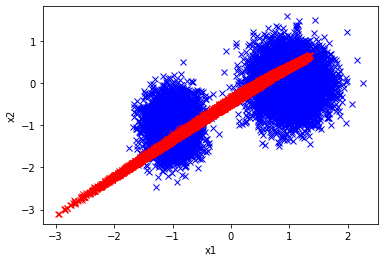

In [63]:
# subplot1
plt.xlabel("x1")
plt.ylabel("x2")   
data = training_data.data.T
plt.plot(data[0], data[1], 'x', color='blue') 
    # subplot2
#model = models[i].eval()
mean = [0, 0]
cov = [[1, 0], [0, 1]]
samples = model_GAN_samples.numpy().T
plt.plot(samples[0], samples[1], 'x', color='red')

In [5]:
from torch import linalg as LA
def kl_divergence_estimation(p_data,q_data,k,order=2):
    #print(type(k))
    #print(type(order))
    #and type(k) == 'int' and (type(order) == 'float' or type(order) == 'int')
    if(p_data.size(dim=1) == q_data.size(dim=1) ):
        N = len(p_data)
        M = len(q_data)
        d = p_data.size(dim=1)
        estimate = torch.tensor([0.0])
        for i in range(N):
            ei_distance_tensor = LA.vector_norm(p_data-p_data[i],ord=order,dim=1,keepdim=True)
            vi_distance_tensor = LA.vector_norm(q_data-p_data[i],ord=order,dim=1,keepdim=True)          
            vi_value,vi_index = torch.kthvalue(vi_distance_tensor, dim=0,k=k)
            ei_value,ei_index = torch.kthvalue(ei_distance_tensor, dim=0,k=k+1) #Increase k by one due to closest data point being itself
            #print("Vi_value: " + str(vi_value) + " Ei_value: " + str(ei_value))
            estimate = estimate + torch.log(vi_value) - torch.log(ei_value)
        estimate = estimate*d/N
        estimate = estimate + torch.log(torch.tensor([M/(N-1)]))
        return estimate
    else:
        return "There is a problem with parameter assumptions"

In [65]:
test = kl_divergence_estimation(training_data.data,model_GAN_samples,k=2)

<class 'int'>
<class 'int'>


In [66]:
test2 = kl_divergence_estimation(training_data.data,model_NVP_samples,k=2)

<class 'int'>
<class 'int'>


In [6]:
#Lambda function to scale -1,1 interval the mnist 255 pixel image
transform_scale_pixel = lambda pixel: (pixel-127.5)/127.5
image_size = 16
dataroot = "C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/"
transform_flatten = lambda pixel: torch.flatten(pixel)
transform_minusone_plusone = tt.Compose([
                                     tt.PILToTensor(),
                                     tt.Lambda(transform_scale_pixel),
                                     tt.Lambda(transform_flatten)
                                           ])
transform_zero_plusone=tt.Compose([
                                    tt.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))
                                  ])
transform_downscale_to_imagesize=tt.Compose([
                               tt.Resize(image_size),
                               tt.CenterCrop(image_size),
                                tt.PILToTensor(),
                                tt.Lambda(transform_scale_pixel),
                                tt.Lambda(transform_flatten)
                           ])

In [8]:
test_data = dset.MNIST(root=dataroot,
                     train=False,
                     transform=transform_minusone_plusone
                           )

In [7]:
test_data_downscaled = dset.MNIST(root=dataroot,
                     train=False,
                     transform=transform_downscale_to_imagesize
                           )

In [41]:
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
D = 4   # input dimension
latent_dim = 2 # number of latents
seed = 3
num_samples = 2000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_quadratic_sqrt_matrix_project_to_4d_plane.pt"]
for dataset in datasets:
    #gan_model_path = result_dir+ dataset.split('/')[-1].replace(".pt", "") +'_quadratic_matrix_project_to_4d_plane_20k_epoch_1e3_g_4e3_d_v2' + '.model'
    gan_model_path = result_dir+ dataset.split('/')[-1].replace(".pt", "") +'_quadratic_sqrt_matrix_project_to_4d_plane_20k_epoch_1e3_g_4e3_d' + '.model'
    nvp_model_path = result_dir+ dataset.split('/')[-1].replace(".pt", "") +'_NVP_1e4lr_1000_epoch_10k_batch_4d_nonlinear_transform' + '.model'
    current_data = torch.load(dataset)
    model = NormalizingFlow4D(32, 20)
    print(nvp_model_path)
    model.load_state_dict(torch.load(nvp_model_path))
    model.training = False
    generator_net = nn.Sequential(nn.Linear(latent_dim, 15), nn.ELU(),
                              nn.Linear(15, 19), nn.ELU(),
                             nn.Linear(19, 15), nn.ELU(),
                             nn.Linear(15, D))
    generator = Generator(generator_net, latent_dim=latent_dim)

    # -discriminator
    discriminator_net = nn.Sequential(nn.Linear(D, 15), nn.ELU(),
                              nn.Linear(15, 37), nn.ELU(),
                             nn.Linear(37, 15), nn.ELU(),
                             nn.Linear(15, 1), nn.Sigmoid())
    discriminator = Discriminator(discriminator_net)
    # Eventually, we initialize the full model
    model_gan = GAN(generator=generator, discriminator=discriminator)
    model_gan.load_state_dict(torch.load(gan_model_path))
    with torch.no_grad():
        model_NVP_samples = model(z_samples).detach()
        model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()
    print(kl_divergence_estimation(current_data,model_NVP_samples,k=2))
    print(kl_divergence_estimation(current_data,model_GAN_samples,k=2))
    

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variance_quadratic_sqrt_matrix_project_to_4d_plane_NVP_1e4lr_1000_epoch_10k_batch_4d_nonlinear_transform.model


KeyboardInterrupt: 

In [171]:
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
D = 2   # input dimension
latent_dim = 2 # number of latents
seed = 3
num_samples = 2000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt"]
for dataset in datasets:
    #gan_model_path = result_dir+ dataset.split('/')[-1].replace(".pt", "") +'_quadratic_matrix_project_to_4d_plane_20k_epoch_1e3_g_4e3_d_v2' + '.model'
    gan_model_path = result_dir+ dataset.split('/')[-1].replace(".pt", "_GAN_higher_lr_result") +'' + '.model'
    nvp_model_path = result_dir+ dataset.split('/')[-1].replace(".pt", "") +'_NVP_10kbatch' + '.model'
    current_data = torch.load(dataset)
    model = NormalizingFlow2D(32, 20)
    print(nvp_model_path)
    model.load_state_dict(torch.load(nvp_model_path))
    model.training = False
    generator_net = nn.Sequential(nn.Linear(latent_dim, 7), nn.ELU(),
                              nn.Linear(7, 13), nn.ELU(),
                             nn.Linear(13, 7), nn.ELU(),
                             nn.Linear(7, D))

    generator = Generator(generator_net, latent_dim=latent_dim)

    # -discriminator
    discriminator_net = nn.Sequential(nn.Linear(D, 11), nn.ELU(),
                              nn.Linear(11, 29), nn.ELU(),
                             nn.Linear(29, 11), nn.ELU(),
                             nn.Linear(11, 1), nn.Sigmoid())
    discriminator = Discriminator(discriminator_net)
    # Eventually, we initialize the full model
    model_gan = GAN(generator=generator, discriminator=discriminator)
    model_gan.load_state_dict(torch.load(gan_model_path))
    with torch.no_grad():
        model_NVP_samples = model(z_samples).detach()
        model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()
    print(kl_divergence_estimation(current_data,model_NVP_samples,k=2))
    print(kl_divergence_estimation(current_data,model_GAN_samples,k=2))
    

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variance_NVP_10kbatch.model
GAN by JT.
tensor([-0.0001], dtype=torch.float64)
tensor([3.8927], dtype=torch.float64)
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_varied_NVP_10kbatch.model
GAN by JT.
tensor([-0.0397], dtype=torch.float64)
tensor([0.3712], dtype=torch.float64)
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_NVP_10kbatch.model
GAN by JT.
tensor([0.1996], dtype=torch.float64)
tensor([6.0040], dtype=torch.float64)
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_high_std_NVP_10kbatch.model
GAN by JT.
tensor([0.0069], dtype=torch.float64)
tensor([0.3974], dtype=torch.float64)
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/no_structure_NVP_10kbatch.model
GAN by JT.
tensor([0.0306], dtype=torch.float64)
tensor([3.6120], dtype=torch.float64)
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_circles_NVP_10kbatch.model
GAN by 

In [9]:
D = 256   # input dimension
latent_dim = 100 # number of latent
flow_latent_dim = D
num_samples = len(test_data_downscaled)
M = 256  # the number of neurons in scale (s) and translation (t) nets for Flow Model
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
mnist_test_images = torch.empty((num_samples,D), dtype=torch.float)

In [28]:
D = 784   # input dimension
latent_dim = 100 # number of latent
flow_latent_dim = D
num_samples = 2000
M = 256  # the number of neurons in scale (s) and translation (t) nets for Flow Model
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
mnist_test_images = torch.empty((num_samples,D), dtype=torch.float)

In [18]:
for i in range(len(test_data_downscaled)):
    mnist_test_images[i], mnist_test_label = test_data_downscaled[i]

In [30]:
for i in range(num_samples):
    mnist_test_images[i], mnist_test_label = test_data[i]

In [40]:
gan_model_path='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/GAN_MNIST_5kepoch_dim64_higher_parameter.model'
generator_net = nn.Sequential(nn.Linear(latent_dim, 336), nn.ELU(),
                          nn.Linear(336, 448), nn.ELU(),
                         nn.Linear(448, 336), nn.ELU(),
                         nn.Linear(336, D))
generator = Generator(generator_net, latent_dim=latent_dim)

# -discriminator
discriminator_net = nn.Sequential(nn.Linear(D, 280), nn.ELU(),
                          nn.Linear(280, 840), nn.ELU(),
                         nn.Linear(840, 280), nn.ELU(),
                         nn.Linear(280, 1), nn.Sigmoid())
discriminator = Discriminator(discriminator_net)
model_gan = GAN(generator=generator, discriminator=discriminator)
model_gan.load_state_dict(torch.load(gan_model_path))
with torch.no_grad():
    model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()
gan_divergence = kl_divergence_estimation(mnist_test_images,model_GAN_samples,k=2)
print(gan_divergence)


RuntimeError: Error(s) in loading state_dict for GAN:
	size mismatch for generator.generator_net.0.weight: copying a param with shape torch.Size([336, 100]) from checkpoint, the shape in current model is torch.Size([336, 2]).
	size mismatch for generator.generator_net.6.weight: copying a param with shape torch.Size([256, 336]) from checkpoint, the shape in current model is torch.Size([4, 336]).
	size mismatch for generator.generator_net.6.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for discriminator.discriminator_net.0.weight: copying a param with shape torch.Size([280, 256]) from checkpoint, the shape in current model is torch.Size([280, 4]).

In [39]:
gan_model_path='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/GAN_MNIST_10kepoch.model'
generator_net = nn.Sequential(nn.Linear(latent_dim, 168), nn.ELU(),
                          nn.Linear(168, 224), nn.ELU(),
                         nn.Linear(224, 168), nn.ELU(),
                         nn.Linear(168, D))
generator = Generator(generator_net, latent_dim=latent_dim)

# -discriminator
discriminator_net = nn.Sequential(nn.Linear(D, 140), nn.ELU(),
                          nn.Linear(140, 336), nn.ELU(),
                         nn.Linear(336, 140), nn.ELU(),
                         nn.Linear(140, 1), nn.Sigmoid())
discriminator = Discriminator(discriminator_net)
model_gan = GAN(generator=generator, discriminator=discriminator)
model_gan.load_state_dict(torch.load(gan_model_path))
with torch.no_grad():
    model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()
gan_divergence = kl_divergence_estimation(mnist_test_images,model_GAN_samples,k=2)
print(gan_divergence)

RuntimeError: Error(s) in loading state_dict for GAN:
	size mismatch for generator.generator_net.0.weight: copying a param with shape torch.Size([168, 100]) from checkpoint, the shape in current model is torch.Size([168, 2]).
	size mismatch for generator.generator_net.6.weight: copying a param with shape torch.Size([784, 168]) from checkpoint, the shape in current model is torch.Size([4, 168]).
	size mismatch for generator.generator_net.6.bias: copying a param with shape torch.Size([784]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for discriminator.discriminator_net.0.weight: copying a param with shape torch.Size([140, 784]) from checkpoint, the shape in current model is torch.Size([140, 4]).

In [96]:
mnist_test_images[0]

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -0.9373, -0.8431, -0.8745, -0.9608, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -0.3725,  0.3412,  0.2392, -0.1059, -0.3255,
        -0.3333, -0.3333, -0.3412, -0.4275, -0.8353, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -0.6078, -0.2314, -0.1137,  0.2941,  0.3804,
         0.4588,  0.4824,  0.4510,  0.7176, -0.3647, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.00

In [54]:
tt.functional.to_pil_image(mnist_test_images[2].reshape(28,28))

RuntimeError: shape '[28, 28]' is invalid for input of size 256

In [59]:
tt.functional.to_pil_image(mnist_test_images[444].reshape(16,16))

In [105]:
tt.functional.to_pil_image(model_NVP_samples[10].reshape(16,16))

In [106]:
tt.functional.to_pil_image(model_GAN_samples[10].reshape(16,16))

In [28]:
nvp_parameters = sum(p.numel() for p in model_nvp.parameters() if p.requires_grad)

In [29]:
gan_parameters = sum(p.numel() for p in model_gan.parameters() if p.requires_grad)

In [14]:
import math
#The number of neurons M should be not less than the dimension N of the vector y,
#but it can be larger

#Total MDL
#criterion for the ANN with M neurons and K connections can be roughly estimated as

#L = nDlog2E + log2M + log2K + 0.5(M+K)log2n
#n = Sample size
#D = data dimensionality
#E is the error will use estimated KL divergence
#K is the number of connections and M is the number of neurons they contribute log2(K*M) so we will use parameter count from torch

def estimated_mdl(model_parameter_size,D,sample_size,estimated_divergence):
        estimated_mdl = sample_size*D*math.log2(estimated_divergence) + math.log2(model_parameter_size) + model_parameter_size/2*math.log2(sample_size)
        return estimated_mdl

In [30]:
gan_estimated_mdl = estimated_mdl(gan_parameters,D,num_samples,gan_divergence)
print(gan_estimated_mdl)

17154085.80165607


In [31]:
nvp_estimated_mdl = estimated_mdl(nvp_parameters,D,num_samples,nvp_divergence)
print(nvp_estimated_mdl)

35542912.70809403


In [16]:
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
D = 4   # input dimension
latent_dim = 2 # number of latents
seed = 3
num_samples = 2000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt"]
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_high_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_low_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_test.pt"]
datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_quadratic_sqrt_matrix_project_to_4d_plane.pt"]
for dataset in datasets:
    #gan_model_path = result_dir+ dataset.split('/')[-1].replace(".pt", "") +'_quadratic_matrix_project_to_4d_plane_20k_epoch_1e3_g_4e3_d_v2' + '.model'
    #gan_model_path = result_dir+ dataset.split('/')[-1].replace(".pt", "_GAN_higher_lr_result") +'' + '.model'
    #nvp_model_path = result_dir+ dataset.split('/')[-1].replace(".pt", "") +'_NVP_10kbatch' + '.model'
    #gan_model_path = result_dir+ dataset.split('/')[-1].replace("_test.pt", "_GAN_higher_lr_result") +'' + '.model'
    #nvp_model_path = result_dir+ dataset.split('/')[-1].replace("_test.pt", "") +'_NVP_10kbatch' + '.model'
    gan_model_path = result_dir+ dataset.split('/')[-1].replace(".pt", "") +'_2k_epoch_1e3_g_4e3_d_v2_increased_last' + '.model'
    nvp_model_path = result_dir+ dataset.split('/')[-1].replace(".pt", "") +'_NVP_1e4lr_2000_epoch_10k_batch_4d_nonlinear_transform_reduced' + '.model'
    current_data = torch.load(dataset)
    model_nvp = NormalizingFlow4D(16, 10)
    print(nvp_model_path)
    model_nvp.load_state_dict(torch.load(nvp_model_path))
    model_nvp.training = False
    generator_net = nn.Sequential(nn.Linear(latent_dim, 15), nn.ELU(),
                              nn.Linear(15, 45), nn.ELU(),
                             nn.Linear(45, 135), nn.ELU(),
                            nn.Linear(135, 270), nn.ELU(),
                            nn.Linear(270, 135), nn.ELU(),
                            nn.Linear(135, 45), nn.ELU(),
                            nn.Linear(45, 15), nn.ELU(),
                             nn.Linear(15, D))
    generator = Generator(generator_net, latent_dim=latent_dim)

    # -discriminator
    discriminator_net = nn.Sequential(nn.Linear(D, 15), nn.ELU(),
                              nn.Linear(15, 75), nn.ELU(),
                             nn.Linear(75, 225), nn.ELU(),
                            nn.Linear(225, 450), nn.ELU(),
                            nn.Linear(450, 225), nn.ELU(),
                             nn.Linear(225, 75), nn.ELU(),
                            nn.Linear(75, 15), nn.ELU(),
                             nn.Linear(15, 1), nn.Sigmoid())
    discriminator = Discriminator(discriminator_net)
    # Eventually, we initialize the full model
    model_gan = GAN(generator=generator, discriminator=discriminator)
    model_gan.load_state_dict(torch.load(gan_model_path))
    with torch.no_grad():
        model_NVP_samples = model(z_samples).detach()
        model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()  
    nvp_divergence = kl_divergence_estimation(current_data,model_NVP_samples,k=2)
    gan_divergence = kl_divergence_estimation(current_data,model_GAN_samples,k=2)
    print(nvp_divergence)
    print(gan_divergence)
    nvp_parameters = sum(p.numel() for p in model_nvp.parameters() if p.requires_grad)
    gan_parameters = sum(p.numel() for p in model_gan.parameters() if p.requires_grad)
    print(nvp_parameters)
    print(gan_parameters)
    nvp_estimated_mdl = estimated_mdl(nvp_parameters,D,num_samples,abs(nvp_divergence))
    gan_estimated_mdl = estimated_mdl(gan_parameters,D,num_samples,abs(gan_divergence))
    print(nvp_estimated_mdl)
    print(gan_estimated_mdl)
    

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variance_quadratic_sqrt_matrix_project_to_4d_plane_NVP_1e4lr_2000_epoch_10k_batch_4d_nonlinear_transform_reduced.model
GAN by JT.
tensor([2.8416], dtype=torch.float64)
tensor([14.7967], dtype=torch.float64)
8720
326810
59877.7166316022
1822979.9121475047
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_varied_quadratic_sqrt_matrix_project_to_4d_plane_NVP_1e4lr_2000_epoch_10k_batch_4d_nonlinear_transform_reduced.model
GAN by JT.
tensor([8.2639], dtype=torch.float64)
tensor([7.8983], dtype=torch.float64)
8720
326810
72198.47011026306
1815734.623502974
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_quadratic_sqrt_matrix_project_to_4d_plane_NVP_1e4lr_2000_epoch_10k_batch_4d_nonlinear_transform_reduced.model
GAN by JT.
tensor([27.1012], dtype=torch.float64)
tensor([27.1146], dtype=torch.float64)
8720
326810
85906.17056325544
1829970.2710249813
C:/Users/aligursu/Desktop/Dersler/Tez_kod

In [31]:
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
num_coupling_array=[4,8,16,32,64]
width_array=[2,5,10,20,40]
D = 2   # input dimension
seed = 3
num_samples = 2000
num_training_samples = 10000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_low_variance_test.pt"]
datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_high_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_low_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_low_variance_test.pt"]
for i,(num_coupling,width) in enumerate(zip(num_coupling_array, width_array)):
    for dataset in datasets:
        #nvp_model_path = result_dir+ dataset.split('/')[-1].replace(".pt", "") +'_complexity_' +'num_coupling_' +str(num_coupling) +'_width_'+ str(width) + '.model'
        dataset_name = dataset.split('/')[-1].replace("high_variance","varied").replace("_low_std","").replace("_low_noise","")
        nvp_model_path = result_dir+ dataset_name.replace("_test.pt", "") +'_complexity_' +'num_coupling_' +str(num_coupling) +'_width_'+ str(width) + '.model'
        current_data = torch.load(dataset)
        model_nvp = NormalizingFlow2D(num_coupling=num_coupling, width=width)
        print(nvp_model_path)
        model_nvp.load_state_dict(torch.load(nvp_model_path))
        model_nvp.training = False
        with torch.no_grad():
            model_NVP_samples = model_nvp(z_samples).detach()
        nvp_divergence = kl_divergence_estimation(current_data,model_NVP_samples,k=2)
        print(nvp_divergence)
        nvp_parameters = sum(p.numel() for p in model_nvp.parameters() if p.requires_grad)
        print(nvp_parameters)
        nvp_estimated_mdl = estimated_mdl(nvp_parameters,D,num_training_samples,abs(nvp_divergence))
        print(nvp_estimated_mdl)
        

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variance_complexity_num_coupling_4_width_2.model
tensor([6.7264], dtype=torch.float64)
156
56040.39009131066
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_varied_complexity_num_coupling_4_width_2.model
tensor([3.2831], dtype=torch.float64)
156
35345.129026116614
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_complexity_num_coupling_4_width_2.model
tensor([6.4655], dtype=torch.float64)
156
54899.05876577927
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_high_std_complexity_num_coupling_4_width_2.model
tensor([4.7558], dtype=torch.float64)
156
46037.77182749432
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/no_structure_complexity_num_coupling_4_width_2.model
tensor([0.6475], dtype=torch.float64)
156
-11497.383331526305
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_circles_complexity_num_coupling_4_width_2.model
tensor([0.4198]

tensor([0.0896], dtype=torch.float64)
435392
2823088.964676533
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_circles_high_noise_complexity_num_coupling_64_width_40.model
tensor([0.0224], dtype=torch.float64)
435392
2783091.0918486663
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_moons_complexity_num_coupling_64_width_40.model
tensor([0.1513], dtype=torch.float64)
435392
2838211.5279570185
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_moons_high_noise_complexity_num_coupling_64_width_40.model
tensor([-0.0241], dtype=torch.float64)
435392
2785225.4201172404
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_t_mixture_low_variance_complexity_num_coupling_64_width_40.model
tensor([-0.0076], dtype=torch.float64)
435392
2751885.7156638037


C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variance_complexity_num_coupling_4_width_2.model
tensor([6.7264], dtype=torch.float64)
156
56040.39009131066
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_varied_complexity_num_coupling_4_width_2.model
tensor([3.2831], dtype=torch.float64)
156
35345.129026116614
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_complexity_num_coupling_4_width_2.model
tensor([6.4655], dtype=torch.float64)
156
54899.05876577927
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_high_std_complexity_num_coupling_4_width_2.model
tensor([4.7558], dtype=torch.float64)
156
46037.77182749432
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/no_structure_complexity_num_coupling_4_width_2.model
tensor([0.6475], dtype=torch.float64)
156
-11497.383331526305
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_circles_complexity_num_coupling_4_width_2.model
tensor([0.4198]

tensor([0.0896], dtype=torch.float64)
435392
2823088.964676533
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_circles_high_noise_complexity_num_coupling_64_width_40.model
tensor([0.0224], dtype=torch.float64)
435392
2783091.0918486663
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_moons_complexity_num_coupling_64_width_40.model
tensor([0.1513], dtype=torch.float64)
435392
2838211.5279570185
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_moons_high_noise_complexity_num_coupling_64_width_40.model
tensor([-0.0241], dtype=torch.float64)
435392
2785225.4201172404
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_t_mixture_low_variance_complexity_num_coupling_64_width_40.model
tensor([-0.0076], dtype=torch.float64)
435392
2751885.7156638037


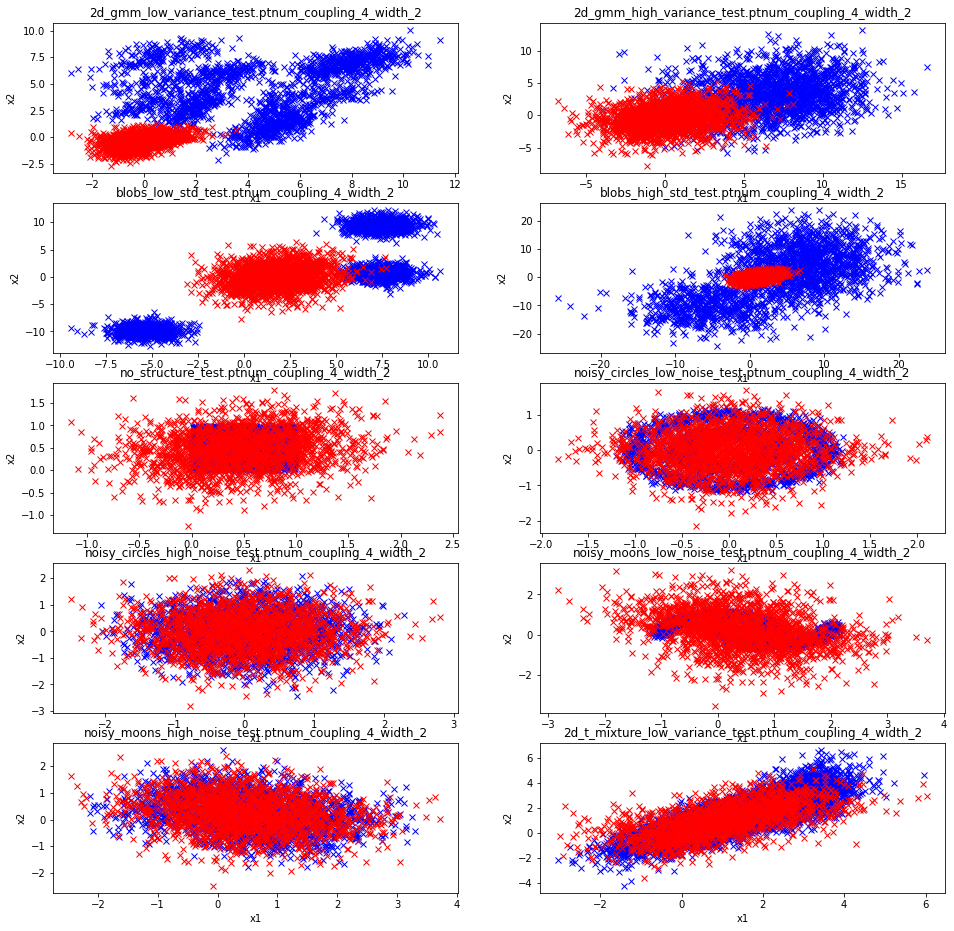

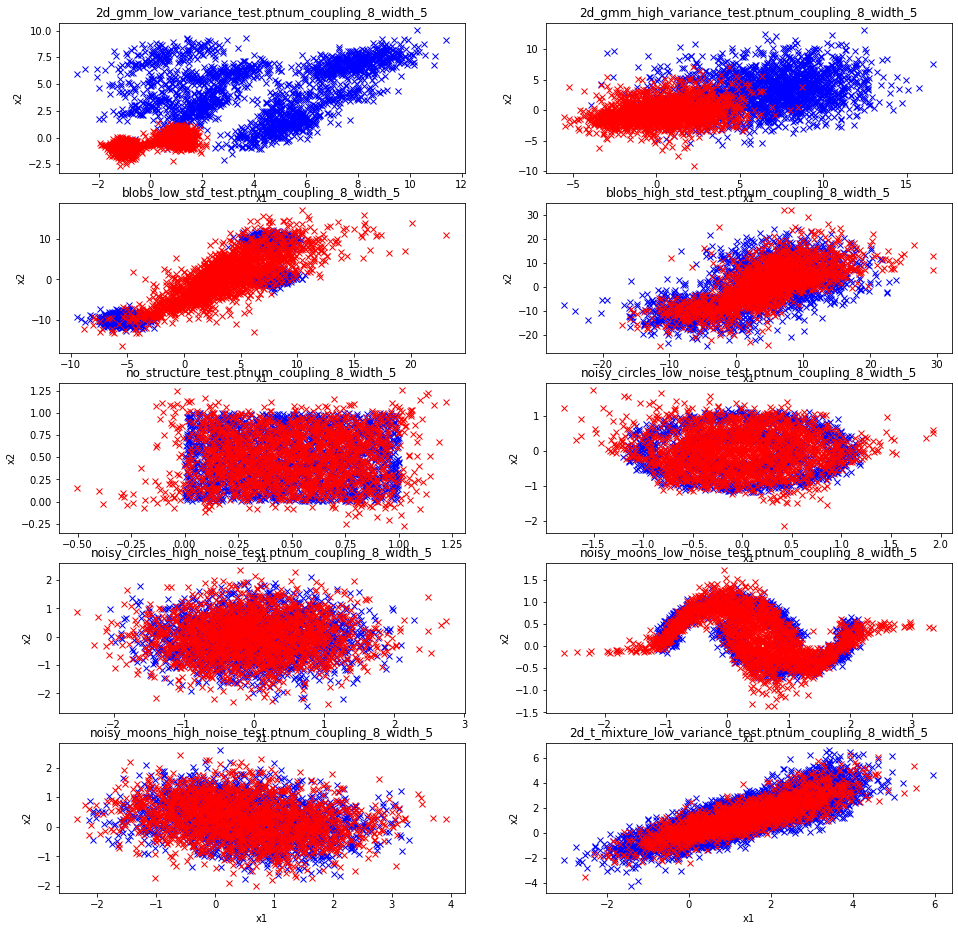

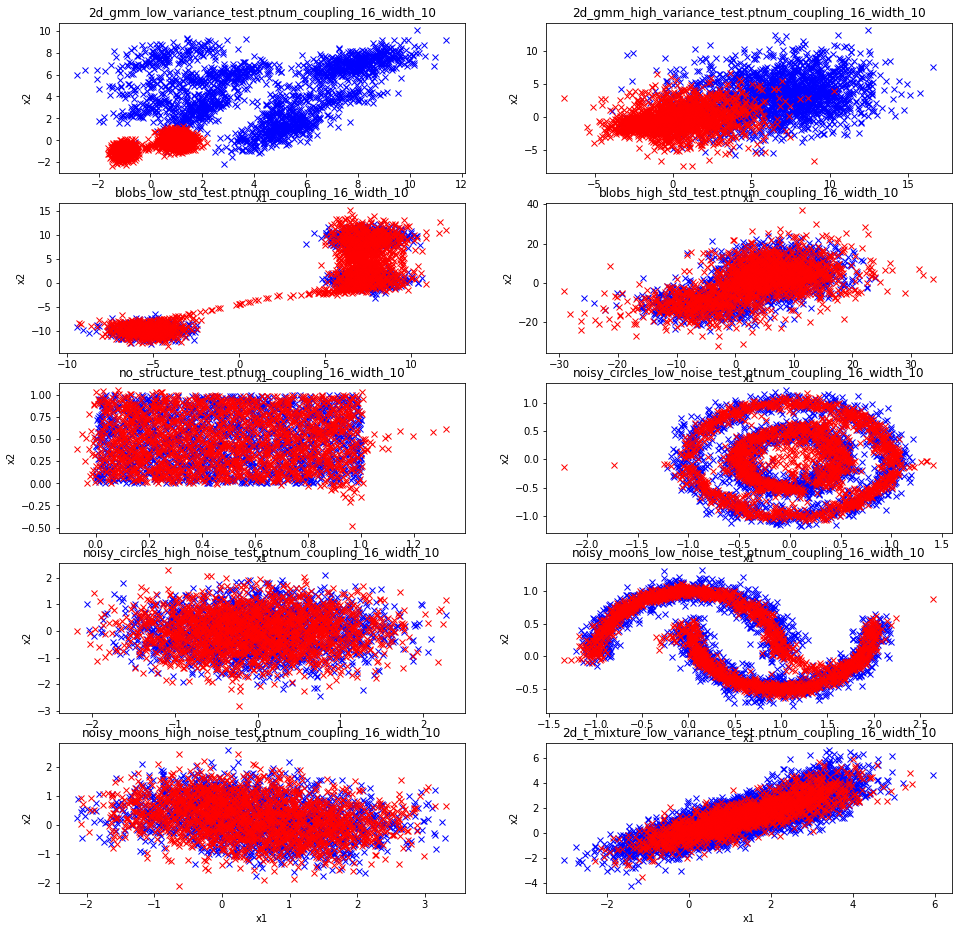

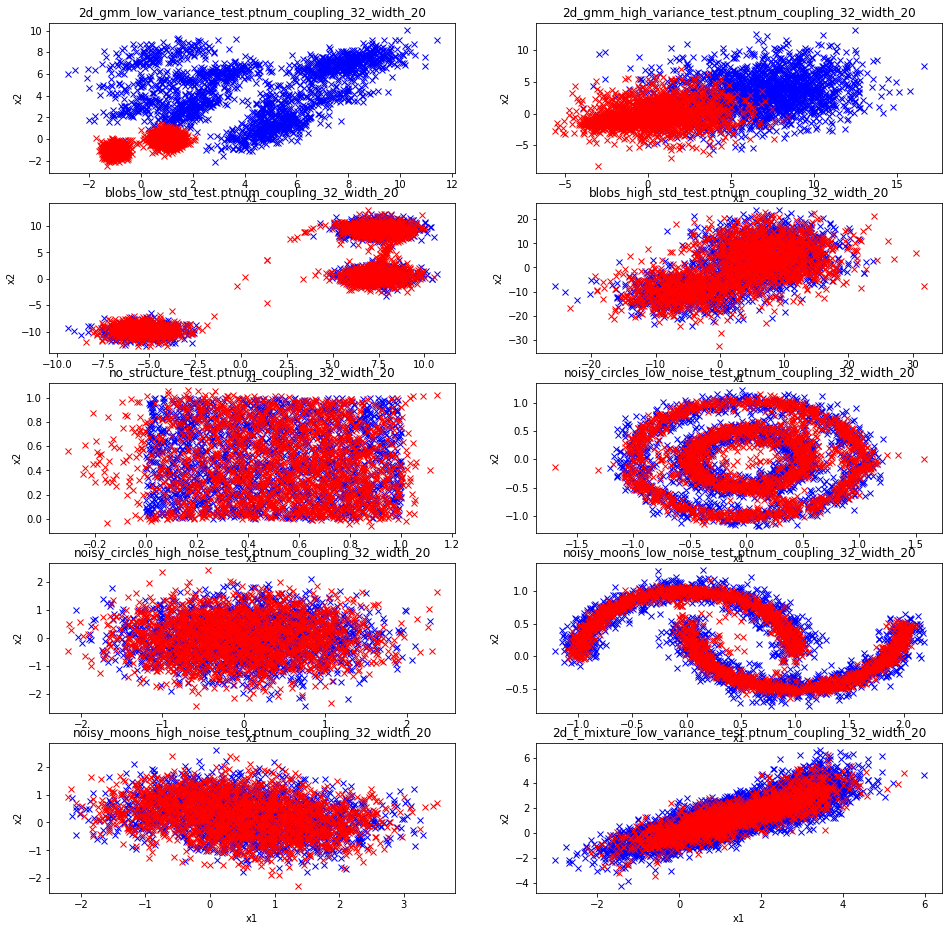

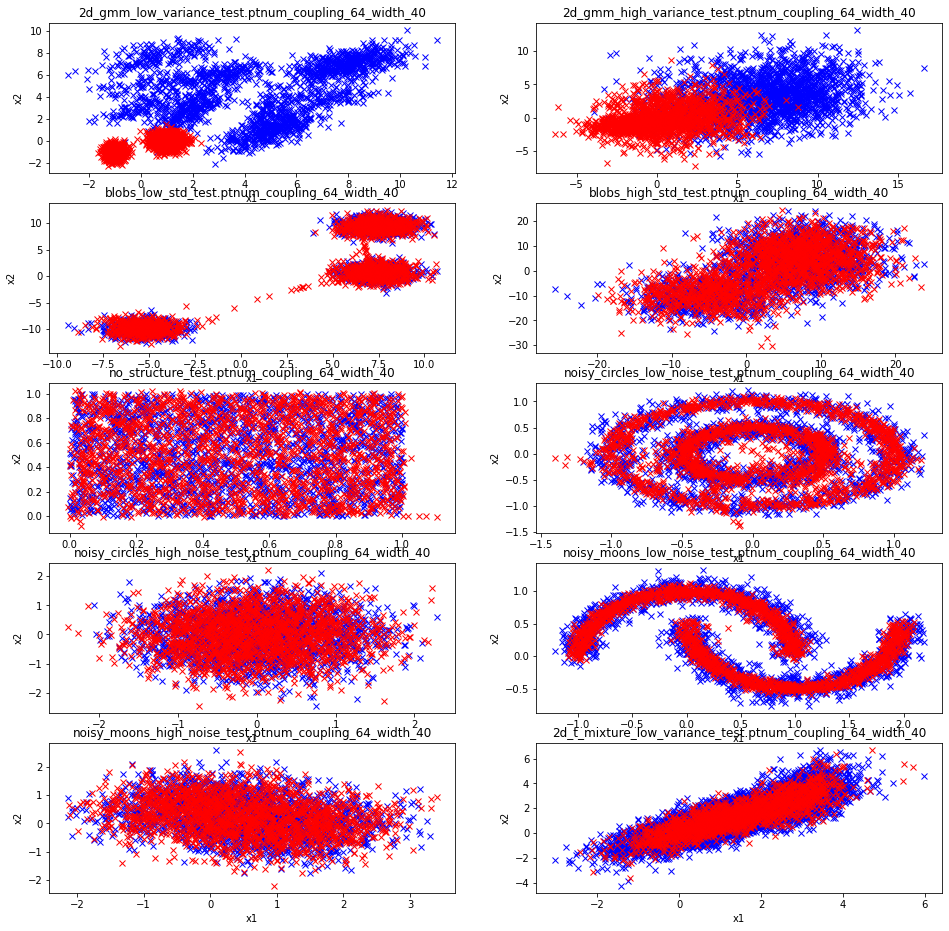

In [96]:
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
num_coupling_array=[4,8,16,32,64]
width_array=[2,5,10,20,40]
D = 2   # input dimension
seed = 3
num_samples = 2000
num_training_samples = 10000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_low_variance_test.pt"]
datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_high_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_low_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_low_variance_test.pt"]
for i,(num_coupling,width) in enumerate(zip(num_coupling_array, width_array)):
    training_data = []
    model_data = []
    for dataset in datasets:
        #nvp_model_path = result_dir+ dataset.split('/')[-1].replace(".pt", "") +'_complexity_' +'num_coupling_' +str(num_coupling) +'_width_'+ str(width) + '.model'
        dataset_name = dataset.split('/')[-1].replace("high_variance","varied").replace("_low_std","").replace("_low_noise","")
        nvp_model_path = result_dir+ dataset_name.replace("_test.pt", "") +'_complexity_' +'num_coupling_' +str(num_coupling) +'_width_'+ str(width) + '.model'
        current_data = torch.load(dataset)
        model_nvp = NormalizingFlow2D(num_coupling=num_coupling, width=width)
        print(nvp_model_path)
        model_nvp.load_state_dict(torch.load(nvp_model_path))
        model_nvp.training = False
        with torch.no_grad():
            model_NVP_samples = model_nvp(z_samples).detach()
        nvp_divergence = kl_divergence_estimation(current_data,model_NVP_samples,k=2)
        print(nvp_divergence)
        nvp_parameters = sum(p.numel() for p in model_nvp.parameters() if p.requires_grad)
        print(nvp_parameters)
        nvp_estimated_mdl = estimated_mdl(nvp_parameters,D,num_training_samples,abs(nvp_divergence))
        print(nvp_estimated_mdl)
        training_data.append(current_data)
        model_data.append(model_NVP_samples)
    fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6), (ax7, ax8),(ax9, ax10)) = plt.subplots(5, 2, figsize=(16,16))
    for i, (train_data, ax) in enumerate(zip(training_data, [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10])):
        # subplot1
        ax.set_title(datasets[i].split('/')[-1] + 'num_coupling_' +str(num_coupling) +'_width_'+ str(width))
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
    
        data = train_data.numpy().T
        ax.plot(data[0], data[1], 'x', color='blue')
        samples = model_data[i].numpy().T
        ax.plot(samples[0], samples[1], 'x', color='red')
        

In [34]:
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
num_coupling_array=[4,8,16,32,64]
width_array=[2,5,10,20,40]
D = 4   # input dimension
seed = 3
num_samples = 2000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_quadratic_matrix_project_to_4d_plane.pt"]
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_quadratic_sqrt_matrix_project_to_4d_plane.pt"]
datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_test_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_high_variance_test_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_low_std_test_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_test_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_test_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_low_noise_test_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_test_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_low_noise_test_quadratic_sqrt_matrix_project_to_4d_plane.pt"]
for i,(num_coupling,width) in enumerate(zip(num_coupling_array, width_array)):
    for dataset in datasets:
        dataset_name = dataset.split('/')[-1].replace("high_variance","varied").replace("_low_std","").replace("_low_noise","").replace("_test","")
        nvp_model_path = result_dir+ dataset_name.replace(".pt", "") +'_complexity_' +'num_coupling_' +str(num_coupling) +'_width_'+ str(width) + '.model'
        #nvp_model_path = result_dir+ dataset.split('/')[-1].replace(".pt", "") +'_complexity_' +'num_coupling_' +str(num_coupling) +'_width_'+ str(width) + '.model'
        current_data = torch.load(dataset)
        model_nvp = NormalizingFlow4D(num_coupling=num_coupling, width=width)
        print(nvp_model_path)
        model_nvp.load_state_dict(torch.load(nvp_model_path))
        model_nvp.training = False
        with torch.no_grad():
            model_NVP_samples = model_nvp(z_samples).detach()
        nvp_divergence = kl_divergence_estimation(current_data,model_NVP_samples,k=2)
        print(nvp_divergence)
        nvp_parameters = sum(p.numel() for p in model_nvp.parameters() if p.requires_grad)
        print(nvp_parameters)
        nvp_estimated_mdl = estimated_mdl(nvp_parameters,D,num_samples,abs(nvp_divergence))
        print(nvp_estimated_mdl)
        

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variance_quadratic_sqrt_matrix_project_to_4d_plane_complexity_num_coupling_4_width_2.model
tensor([18.8509], dtype=torch.float64)
196
34974.726548259365
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_varied_quadratic_sqrt_matrix_project_to_4d_plane_complexity_num_coupling_4_width_2.model
tensor([18.4247], dtype=torch.float64)
196
34710.79384252729
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_quadratic_sqrt_matrix_project_to_4d_plane_complexity_num_coupling_4_width_2.model
tensor([22.9247], dtype=torch.float64)
196
37232.88731988323
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_high_std_quadratic_sqrt_matrix_project_to_4d_plane_complexity_num_coupling_4_width_2.model
tensor([18.2434], dtype=torch.float64)
196
34596.65420406811
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/no_structure_quadratic_sqrt_matrix_project_to_4d_plane_complexity_num_co

tensor([1.8138], dtype=torch.float64)
445760
2450944.814492637
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_circles_high_noise_quadratic_sqrt_matrix_project_to_4d_plane_complexity_num_coupling_64_width_40.model
tensor([0.2210], dtype=torch.float64)
445760
2426649.1661678036
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_moons_quadratic_sqrt_matrix_project_to_4d_plane_complexity_num_coupling_64_width_40.model
tensor([9.2436], dtype=torch.float64)
445760
2469740.3587693963


In [79]:
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
#num_coupling_array=[4,8,16,32,64]
#width_array=[2,5,10,20,40]
num_coupling_array=[80,96,102,128]
width_array=[50,60,70,80]
D = 256   # input dimension
seed = 3
num_samples = 10000
num_training_samples = 60000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
for i,(num_coupling,width) in enumerate(zip(num_coupling_array, width_array)):    
        nvp_model_path = result_dir+ 'MNIST16x16' +'_complexity_' +'num_coupling_' +str(num_coupling) +'_width_'+ str(width) + '.model'
        model_nvp = NormalizingFlowMNISTReduced(num_coupling=num_coupling, width=width)
        print(nvp_model_path)
        model_nvp.load_state_dict(torch.load(nvp_model_path))
        model_nvp.training = False
        with torch.no_grad():
            model_NVP_samples = model_nvp(z_samples).detach()
        nvp_divergence = kl_divergence_estimation(mnist_test_images,model_NVP_samples,k=2)
        print(nvp_divergence)
        nvp_parameters = sum(p.numel() for p in model_nvp.parameters() if p.requires_grad)
        print(nvp_parameters)
        nvp_estimated_mdl = estimated_mdl(nvp_parameters,D,num_training_samples,abs(nvp_divergence))
        print(nvp_estimated_mdl)

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST16x16_complexity_num_coupling_80_width_50.model
tensor([54.8563])
2892560
111700058.05744134
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST16x16_complexity_num_coupling_96_width_60.model
tensor([45.1414])
4390752
119270894.77184653
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST16x16_complexity_num_coupling_102_width_70.model
tensor([42.5077])
5723934
128519342.45158386
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST16x16_complexity_num_coupling_128_width_80.model


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST16x16_complexity_num_coupling_128_width_80.model'

In [28]:
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
#num_coupling_array=[4,8,16,32,64]
#width_array=[2,5,10,20,40]
num_coupling_array=[4,8,16,32,64,80,96]
width_array=[2,5,10,20,40,50,60]
D = 784   # input dimension
seed = 3
num_samples = 10000
num_training_samples = 60000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
for i,(num_coupling,width) in enumerate(zip(num_coupling_array, width_array)):    
        nvp_model_path = result_dir+ 'MNIST28' +'_complexity_' +'num_coupling_' +str(num_coupling) +'_width_'+ str(width) + '.model'
        model_nvp = NormalizingFlowMNIST(num_coupling=num_coupling, width=width)
        print(nvp_model_path)
        model_nvp.load_state_dict(torch.load(nvp_model_path))
        model_nvp.training = False
        with torch.no_grad():
            model_NVP_samples = model_nvp(z_samples).detach()
        nvp_divergence = kl_divergence_estimation(mnist_test_images,model_NVP_samples,k=2)
        print(nvp_divergence)
        nvp_parameters = sum(p.numel() for p in model_nvp.parameters() if p.requires_grad)
        print(nvp_parameters)
        nvp_estimated_mdl = estimated_mdl(nvp_parameters,D,num_training_samples,abs(nvp_divergence))
        print(nvp_estimated_mdl)

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST28_complexity_num_coupling_4_width_2.model
tensor([366.8908])
15796
400868865.6293277
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST28_complexity_num_coupling_8_width_5.model
tensor([690.0610])
70040
444170361.9944298
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST28_complexity_num_coupling_16_width_10.model
tensor([392.1704])
270800
407414619.58761466
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST28_complexity_num_coupling_32_width_20.model
tensor([272.4014])
1083680
389134790.11062616
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST28_complexity_num_coupling_64_width_40.model
tensor([161.4538])
4489280
380665813.6102163
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST28_complexity_num_coupling_80_width_50.model
tensor([152.9371])
7158800
398174302.04559207
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST28_complexi

In [12]:
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
D = 2   # input dimension
latent_dim = 2 # number of latents
seed = 3
lr_gen = 1e-3 # learning rate
lr_dis = 4e-3 # learning rate
generator_layer_sizes = np.array([[3, 5, 7, 13],
                       [6, 10, 14, 26],
                       [15, 25, 35, 65],
                        [30, 50, 70, 130],
                        [45, 75, 105, 195]
                       ])
discriminator_layer_sizes = np.array([[5, 7, 11, 29],
                       [10, 14, 22, 58],
                       [25, 35, 55, 145],
                        [50, 70, 110, 290],
                        [75, 105, 165, 435]
                       ])
num_samples = 2000
num_training_samples = 10000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_low_variance_test.pt"]
for i,(gen_layer,disc_layer) in enumerate(zip(generator_layer_sizes, discriminator_layer_sizes)):   
    for name in datasets:
        gan_model_path = result_dir+ name.split('/')[-1].replace(".pt", "")+ 'gen_lr_' + str(lr_gen) +'_gen_max_'+ str(gen_layer[3]) + 'disc_lr_'+ str(lr_dis)+ '_disc_max' +str(disc_layer[3]) +'.model'
        generator_net = nn.Sequential(nn.Linear(latent_dim, gen_layer[0]), nn.ELU(),
                              nn.Linear(gen_layer[0], gen_layer[1]), nn.ELU(),
                             nn.Linear(gen_layer[1], gen_layer[2]), nn.ELU(),
                            nn.Linear(gen_layer[2], gen_layer[3]), nn.ELU(),
                            nn.Linear(gen_layer[3], gen_layer[2]), nn.ELU(),
                            nn.Linear(gen_layer[2], gen_layer[1]), nn.ELU(),
                            nn.Linear(gen_layer[1], gen_layer[0]), nn.ELU(),
                             nn.Linear(gen_layer[0], D))
        generator = Generator(generator_net, latent_dim=latent_dim)

        # -discriminator
        discriminator_net = nn.Sequential(nn.Linear(D, disc_layer[0]), nn.ELU(),
                              nn.Linear(disc_layer[0], disc_layer[1]), nn.ELU(),
                             nn.Linear(disc_layer[1], disc_layer[2]), nn.ELU(),
                            nn.Linear(disc_layer[2], disc_layer[3]), nn.ELU(),
                            nn.Linear(disc_layer[3], disc_layer[2]), nn.ELU(),
                             nn.Linear(disc_layer[2], disc_layer[1]), nn.ELU(),
                            nn.Linear(disc_layer[1], disc_layer[0]), nn.ELU(),
                             nn.Linear(disc_layer[0], 1), nn.Sigmoid())
        discriminator = Discriminator(discriminator_net)
        model_gan = GAN(generator=generator, discriminator=discriminator)
        print(gan_model_path)
        model_gan.load_state_dict(torch.load(gan_model_path))
        current_data = torch.load(name)
        with torch.no_grad():
            model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()  
        gan_divergence = kl_divergence_estimation(current_data,model_GAN_samples,k=2)
        print(gan_divergence)
        gan_parameters = sum(p.numel() for p in model_gan.parameters() if p.requires_grad)
        print(gan_parameters)
        gan_estimated_mdl = estimated_mdl(gan_parameters,D,num_training_samples,abs(gan_divergence))
        print(gan_estimated_mdl)
    

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variancegen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([4.8075], dtype=torch.float64)
1292
53900.13290021928
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_variedgen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([3.5409], dtype=torch.float64)
1292
45076.50296778986
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobsgen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([8.9693], dtype=torch.float64)
1292
71894.24378434362
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_high_stdgen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([4.6665], dtype=torch.float64)
1292
53041.05807433303
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/no_structuregen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([4.8121], dtype=torch.float64)
1292
53927.39354089959
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/no

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_t_mixture_low_variance_testgen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model'

In [13]:
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
D = 2   # input dimension
latent_dim = 2 # number of latents
seed = 3
lr_gen = 1e-3 # learning rate
lr_dis = 4e-3 # learning rate
generator_layer_sizes = np.array([[3, 5, 7, 13],
                       [6, 10, 14, 26],
                       [15, 25, 35, 65],
                        [30, 50, 70, 130],
                        [45, 75, 105, 195]
                       ])
discriminator_layer_sizes = np.array([[5, 7, 11, 29],
                       [10, 14, 22, 58],
                       [25, 35, 55, 145],
                        [50, 70, 110, 290],
                        [75, 105, 165, 435]
                       ])
num_samples = 2000
num_training_samples = 10000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_low_variance_test.pt"]
datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_high_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_low_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_low_variance_test.pt"]
for i,(gen_layer,disc_layer) in enumerate(zip(generator_layer_sizes, discriminator_layer_sizes)):   
    for name in datasets:
        model_name = name.split('/')[-1].replace("high_variance","varied").replace("_low_std","").replace("_low_noise","").replace("_test","")
        gan_model_path = result_dir+ model_name.split('/')[-1].replace(".pt", "")+ 'gen_lr_' + str(lr_gen) +'_gen_max_'+ str(gen_layer[3]) + 'disc_lr_'+ str(lr_dis)+ '_disc_max' +str(disc_layer[3]) +'.model'
        generator_net = nn.Sequential(nn.Linear(latent_dim, gen_layer[0]), nn.ELU(),
                              nn.Linear(gen_layer[0], gen_layer[1]), nn.ELU(),
                             nn.Linear(gen_layer[1], gen_layer[2]), nn.ELU(),
                            nn.Linear(gen_layer[2], gen_layer[3]), nn.ELU(),
                            nn.Linear(gen_layer[3], gen_layer[2]), nn.ELU(),
                            nn.Linear(gen_layer[2], gen_layer[1]), nn.ELU(),
                            nn.Linear(gen_layer[1], gen_layer[0]), nn.ELU(),
                             nn.Linear(gen_layer[0], D))
        generator = Generator(generator_net, latent_dim=latent_dim)

        # -discriminator
        discriminator_net = nn.Sequential(nn.Linear(D, disc_layer[0]), nn.ELU(),
                              nn.Linear(disc_layer[0], disc_layer[1]), nn.ELU(),
                             nn.Linear(disc_layer[1], disc_layer[2]), nn.ELU(),
                            nn.Linear(disc_layer[2], disc_layer[3]), nn.ELU(),
                            nn.Linear(disc_layer[3], disc_layer[2]), nn.ELU(),
                             nn.Linear(disc_layer[2], disc_layer[1]), nn.ELU(),
                            nn.Linear(disc_layer[1], disc_layer[0]), nn.ELU(),
                             nn.Linear(disc_layer[0], 1), nn.Sigmoid())
        discriminator = Discriminator(discriminator_net)
        model_gan = GAN(generator=generator, discriminator=discriminator)
        print(gan_model_path)
        model_gan.load_state_dict(torch.load(gan_model_path))
        current_data = torch.load(name)
        with torch.no_grad():
            model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()  
        gan_divergence = kl_divergence_estimation(current_data,model_GAN_samples,k=2)
        print(gan_divergence)
        gan_parameters = sum(p.numel() for p in model_gan.parameters() if p.requires_grad)
        print(gan_parameters)
        gan_estimated_mdl = estimated_mdl(gan_parameters,D,num_training_samples,abs(gan_divergence))
        print(gan_estimated_mdl)
    

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variancegen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([7.0827], dtype=torch.float64)
1292
65080.08434456282
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_variedgen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([6.0422], dtype=torch.float64)
1292
60495.65450898769
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobsgen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([8.9941], dtype=torch.float64)
1292
71973.67927656864
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_high_stdgen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([4.6405], dtype=torch.float64)
1292
52880.014142285894
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/no_structuregen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([4.7311], dtype=torch.float64)
1292
53437.941285582405
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/

tensor([8.8987], dtype=torch.float64)
259578
1787688.8210256712
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_high_stdgen_lr_0.001_gen_max_195disc_lr_0.004_disc_max435.model
tensor([8.5730], dtype=torch.float64)
259578
1786612.9576745809
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/no_structuregen_lr_0.001_gen_max_195disc_lr_0.004_disc_max435.model
tensor([9.4407], dtype=torch.float64)
259578
1789394.7338042178
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_circlesgen_lr_0.001_gen_max_195disc_lr_0.004_disc_max435.model
tensor([4.1304], dtype=torch.float64)
259578
1765542.1926900807
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_circles_high_noisegen_lr_0.001_gen_max_195disc_lr_0.004_disc_max435.model
tensor([2.2032], dtype=torch.float64)
259578
1747408.674136263
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_moonsgen_lr_0.001_gen_max_195disc_lr_0.004_disc_max435.model
tensor([5.0271], dtype=torc

In [11]:
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
D = 2   # input dimension
latent_dim = 1 # number of latents
seed = 3
lr_gen = 1e-3 # learning rate
lr_dis = 4e-3 # learning rate
generator_layer_sizes = np.array([[7, 13],
                       [14, 26,],
                       [35, 65],
                        [70, 130],
                        [105, 165]
                       ])
discriminator_layer_sizes = np.array([[11, 29],
                       [22, 58],
                       [55, 145],
                        [110, 290],
                        [165, 435]
                       ])
num_samples = 2000
num_training_samples = 10000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_low_variance_test.pt"]
datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_high_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_low_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_low_variance_test.pt"]
for i,(gen_layer,disc_layer) in enumerate(zip(generator_layer_sizes, discriminator_layer_sizes)):   
    for name in datasets:
        model_name = name.split('/')[-1].replace("high_variance","varied").replace("_low_std","").replace("_low_noise","").replace("_test","")
        gan_model_path = result_dir + model_name.split('/')[-1].replace(".pt", "")+ 'latent_dim_'+ str(latent_dim) +'_gen_lr_' + str(lr_gen) +'_gen_max_'+ str(gen_layer[1]) + 'disc_lr_'+ str(lr_dis)+ '_disc_max' +str(disc_layer[1]) +'.model'
        #gan_model_path = result_dir+ model_name.split('/')[-1].replace(".pt", "")+ 'gen_lr_' + str(lr_gen) +'_gen_max_'+ str(gen_layer[1]) + 'disc_lr_'+ str(lr_dis)+ '_disc_max' +str(disc_layer[1]) +'.model'
        generator_net = nn.Sequential(nn.Linear(latent_dim, gen_layer[0]), nn.ELU(),
                                    nn.Linear(gen_layer[0], gen_layer[1]), nn.ELU(),
                                    nn.Linear(gen_layer[1], gen_layer[0]), nn.ELU(),
                                     nn.Linear(gen_layer[0], D))
        generator = Generator(generator_net, latent_dim=latent_dim)
        # -discriminator
        discriminator_net = nn.Sequential(nn.Linear(D, disc_layer[0]), nn.ELU(),
                                        nn.Linear(disc_layer[0], disc_layer[1]), nn.ELU(),
                                        nn.Linear(disc_layer[1], disc_layer[0]), nn.ELU(),
                                        nn.Linear(disc_layer[0], 1), nn.Sigmoid())
        discriminator = Discriminator(discriminator_net)
        model_gan = GAN(generator=generator, discriminator=discriminator)
        print(gan_model_path)
        model_gan.load_state_dict(torch.load(gan_model_path))
        current_data = torch.load(name)
        with torch.no_grad():
            model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()  
        gan_divergence = kl_divergence_estimation(current_data,model_GAN_samples,k=2)
        print(gan_divergence)
        gan_parameters = sum(p.numel() for p in model_gan.parameters() if p.requires_grad)
        print(gan_parameters)
        gan_estimated_mdl = estimated_mdl(gan_parameters,D,num_training_samples,abs(gan_divergence))
        print(gan_estimated_mdl)
    

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variancelatent_dim_1_gen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([7.2708], dtype=torch.float64)
955
63597.23917545127
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_variedlatent_dim_1_gen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([4.7402], dtype=torch.float64)
955
51253.52039251046
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobslatent_dim_1_gen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([8.9412], dtype=torch.float64)
955
69564.06563125404
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_high_stdlatent_dim_1_gen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([3.1920], dtype=torch.float64)
955
39844.03418682367
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/no_structurelatent_dim_1_gen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([4.9731], dtype=torch.float64)
955
52637.90343204372
C:

tensor([8.3545], dtype=torch.float64)
180153
1258178.9966286493
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_variedlatent_dim_1_gen_lr_0.001_gen_max_165disc_lr_0.004_disc_max435.model
tensor([5.0180], dtype=torch.float64)
180153
1243470.0675607654
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobslatent_dim_1_gen_lr_0.001_gen_max_165disc_lr_0.004_disc_max435.model
tensor([9.3414], dtype=torch.float64)
180153
1261400.8338358314
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_high_stdlatent_dim_1_gen_lr_0.001_gen_max_165disc_lr_0.004_disc_max435.model
tensor([3.5969], dtype=torch.float64)
180153
1233862.9357446544
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/no_structurelatent_dim_1_gen_lr_0.001_gen_max_165disc_lr_0.004_disc_max435.model
tensor([9.2680], dtype=torch.float64)
180153
1261173.117064617
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_circleslatent_dim_1_gen_lr_0.001_gen_max_165disc_lr_0.0

In [30]:
def min_key_in_dictionary(d):
    value = 0
    min_key = next(iter(d)) 
    # Iterate over the keys in the dictionary
    for key in d:
        # If the value of the current key is greater than the value of max_key, update max_key
        if d[key] < d[min_key]:
            min_key = key
            value = d[min_key] 
    # Print the key with the maximum value
    return(min_key,value)

In [32]:
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
D = 2   # input dimension
latent_dim = 1 # number of latents
seed = 3
generator_layer_sizes = np.array([[7, 13],
                       [14, 26,],
                       [35, 65],
                        [70, 130],
                        [105, 165]
                       ])
discriminator_layer_sizes = np.array([[11, 29],
                       [22, 58],
                       [55, 145],
                        [110, 290],
                        [165, 435]
                       ])
generator_lr_rates = np.array([[1e-2, 2e-2,3e-2,4e-2,5e-2],
                       [1e-3, 2e-3,3e-3,4e-3,5e-3],
                       [1e-4, 2e-4,3e-4,4e-4,5e-4]
                       ])
discriminator_lr_rates =  np.array([[1e-2, 2e-2,3e-2,4e-2,5e-2],
                       [1e-3, 2e-3,3e-3,4e-3,5e-3],
                       [1e-4, 2e-4,3e-4,4e-4,5e-4]
                       ])
num_samples = 2000
num_training_samples = 10000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_high_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_low_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_low_variance_test.pt"]
for name in datasets:
    mdl_values = {}
    kl_values = {}
    print(name)
    for i,(gen_layer,disc_layer) in enumerate(zip(generator_layer_sizes, discriminator_layer_sizes)):
        for index,(gen_lr_level,disc_lr_level) in enumerate(zip(generator_lr_rates, discriminator_lr_rates)):
            for j,gen_lr_rate in enumerate(gen_lr_level):
                for disc_lr_rate in disc_lr_level[j:]:  
                    model_name = name.split('/')[-1].replace("high_variance","varied").replace("_low_std","").replace("_low_noise","").replace("_test","")
                    gan_model_path = result_dir + model_name.split('/')[-1].replace(".pt", "")+ 'latent_dim_'+ str(latent_dim) +'_gen_lr_' + str(gen_lr_rate) +'_gen_max_'+ str(gen_layer[1]) + 'disc_lr_'+ str(disc_lr_rate)+ '_disc_max' +str(disc_layer[1]) +'.model'
                    generator_net = nn.Sequential(nn.Linear(latent_dim, gen_layer[0]), nn.ELU(),
                                    nn.Linear(gen_layer[0], gen_layer[1]), nn.ELU(),
                                    nn.Linear(gen_layer[1], gen_layer[0]), nn.ELU(),
                                     nn.Linear(gen_layer[0], D))
                    generator = Generator(generator_net, latent_dim=latent_dim)
                    # -discriminator
                    discriminator_net = nn.Sequential(nn.Linear(D, disc_layer[0]), nn.ELU(),
                                        nn.Linear(disc_layer[0], disc_layer[1]), nn.ELU(),
                                        nn.Linear(disc_layer[1], disc_layer[0]), nn.ELU(),
                                        nn.Linear(disc_layer[0], 1), nn.Sigmoid())
                    discriminator = Discriminator(discriminator_net)
                    model_gan = GAN(generator=generator, discriminator=discriminator)
                    #print(gan_model_path)
                    model_gan.load_state_dict(torch.load(gan_model_path))
                    current_data = torch.load(name)
                    with torch.no_grad():
                        model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()  
                    gan_divergence = kl_divergence_estimation(current_data,model_GAN_samples,k=2)
                    #print(gan_divergence)
                    gan_parameters = sum(p.numel() for p in model_gan.parameters() if p.requires_grad)
                    #print(gan_parameters)
                    gan_estimated_mdl = estimated_mdl(gan_parameters,D,num_training_samples,abs(gan_divergence))
                    #print(gan_estimated_mdl)
                    del model_gan
    min_kl_model,min_kl_value = min_key_in_dictionary(kl_values)
    min_mdl_model,min_mdl_value = min_key_in_dictionary(mdl_values)
    print("min_kl_model:" + min_kl_model + " and its value is: " + str(min_kl_value))
    print("min_mdl_model:" + min_kl_model + " and its value is: " + str(min_mdl_value))

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_test.pt
min_kl_model:C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variancelatent_dim_1_gen_lr_0.01_gen_max_165disc_lr_0.05_disc_max435.model and its value is: tensor([4.7347], dtype=torch.float64)
min_mdl_model:C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variancelatent_dim_1_gen_lr_0.05_gen_max_13disc_lr_0.05_disc_max29.model and its value is: 54913.753158862855
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_high_variance_test.pt
min_kl_model:C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_variedlatent_dim_1_gen_lr_0.0004_gen_max_130disc_lr_0.0005_disc_max290.model and its value is: tensor([3.7378], dtype=torch.float64)
min_mdl_model:C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_variedlatent_dim_1_gen_lr_0.003_gen_max_13disc_lr_0.004_disc_max29.model and its value is: 48044.4593228735
C:/Users/aligursu/Desktop

In [16]:
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
D = 2   # input dimension
latent_dim = 1 # number of latents
seed = 3
generator_layer_sizes = np.array([[256, 512, 1024],
                       ])
discriminator_layer_sizes = np.array([[1024, 512, 256],
                       ])
lr_gen = 1e-3 # learning rate
lr_dis = 2e-3 # learning rate
num_samples = 2000
num_training_samples = 10000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_high_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_low_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_low_variance_test.pt"]
for name in datasets:
    mdl_values = {}
    kl_values = {}
    print(name)
    for i,(gen_layer,disc_layer) in enumerate(zip(generator_layer_sizes, discriminator_layer_sizes)):
        gen_lr_rate = lr_gen
        disc_lr_rate = lr_dis
        model_name = name.split('/')[-1].replace("high_variance","varied").replace("_low_std","").replace("_low_noise","").replace("_test","")
        #gan_model_path = result_dir+ name.split('/')[-1].replace(".pt", "")+ 'latent_dim_'+ str(latent_dim) + 'network_depth_2' +'_gen_lr_' + str(gen_lr_rate) +'_gen_max_'+ str(gen_layer[1]) + 'disc_lr_'+ str(disc_lr_rate)+ '_disc_max' +str(disc_layer[1]) +'.model')
        gan_model_path = result_dir + model_name.split('/')[-1].replace(".pt", "")+ 'latent_dim_'+ str(latent_dim) + 'network_depth_3' +'_gen_lr_' + str(lr_gen) +'_gen_max_'+ str(gen_layer[2]) + 'disc_lr_'+ str(lr_dis)+ '_disc_max' +str(disc_layer[2]) +'.model'
        generator_net = nn.Sequential(nn.Linear(latent_dim, gen_layer[0]), nn.ELU(),
                            nn.Linear(gen_layer[0], gen_layer[1]), nn.ELU(),
                            nn.Linear(gen_layer[1], gen_layer[2]), nn.ELU(),
                            nn.Linear(gen_layer[2], gen_layer[1]), nn.ELU(),
                            nn.Linear(gen_layer[1], gen_layer[0]), nn.ELU(),
                            nn.Linear(gen_layer[0], D))
        generator = Generator(generator_net, latent_dim=latent_dim)

        # -discriminator
        discriminator_net = nn.Sequential(nn.Linear(D, disc_layer[0]), nn.ELU(),
                            nn.Linear(disc_layer[0], disc_layer[1]), nn.ELU(),
                            nn.Linear(disc_layer[1], disc_layer[2]), nn.ELU(),
                            nn.Linear(disc_layer[2], disc_layer[1]), nn.ELU(),
                            nn.Linear(disc_layer[1], disc_layer[0]), nn.ELU(),
                            nn.Linear(disc_layer[0], 1), nn.Sigmoid())
        discriminator = Discriminator(discriminator_net)
        model_gan = GAN(generator=generator, discriminator=discriminator)
        print(gan_model_path)
        model_gan.load_state_dict(torch.load(gan_model_path))
        current_data = torch.load(name)
        with torch.no_grad():
            model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()  
        gan_divergence = kl_divergence_estimation(current_data,model_GAN_samples,k=2)
        print(gan_divergence)
        gan_parameters = sum(p.numel() for p in model_gan.parameters() if p.requires_grad)
        print(gan_parameters)
        gan_estimated_mdl = estimated_mdl(gan_parameters,D,num_training_samples,abs(gan_divergence))
        print(gan_estimated_mdl)

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_test.pt
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variancelatent_dim_1network_depth_3_gen_lr_0.001_gen_max_1024disc_lr_0.002_disc_max256.model
tensor([8.1771], dtype=torch.float64)
2631171
17541774.820037235
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_high_variance_test.pt
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_variedlatent_dim_1network_depth_3_gen_lr_0.001_gen_max_1024disc_lr_0.002_disc_max256.model
tensor([14.5831], dtype=torch.float64)
2631171
17558467.61618269
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_low_std_test.pt
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobslatent_dim_1network_depth_3_gen_lr_0.001_gen_max_1024disc_lr_0.002_disc_max256.model
tensor([15.9917], dtype=torch.float64)
2631171
17561128.008354325
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_test.pt
C:/Users/aligursu/

In [9]:
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
D = 2   # input dimension
latent_dim = 1 # number of latents
seed = 3
generator_layer_sizes = np.array([[7, 13],
                       [14, 26,],
                       [35, 65],
                        [70, 130],
                        [105, 165]
                       ])
discriminator_layer_sizes = np.array([[11, 29],
                       [22, 58],
                       [55, 145],
                        [110, 290],
                        [165, 435]
                       ])
lr_gen = 1e-3 # learning rate
lr_dis = 4e-3 # learning rate
num_samples = 2000
num_training_samples = 10000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_high_variance_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_low_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_low_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_test.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_low_variance_test.pt"]
for name in datasets:
    mdl_values = {}
    kl_values = {}
    print(name)
    for i,(gen_layer,disc_layer) in enumerate(zip(generator_layer_sizes, discriminator_layer_sizes)):
        gen_lr_rate = lr_gen
        disc_lr_rate = lr_dis
        model_name = name.split('/')[-1].replace("high_variance","varied").replace("_low_std","").replace("_low_noise","").replace("_test","")
        gan_model_path = result_dir + model_name.split('/')[-1].replace(".pt", "")+ 'latent_dim_'+ str(latent_dim) +'_gen_lr_' + str(gen_lr_rate) +'_gen_max_'+ str(gen_layer[1]) + 'disc_lr_'+ str(disc_lr_rate)+ '_disc_max' +str(disc_layer[1]) +'.model'
        generator_net = nn.Sequential(nn.Linear(latent_dim, gen_layer[0]), nn.ELU(),
                                    nn.Linear(gen_layer[0], gen_layer[1]), nn.ELU(),
                                    nn.Linear(gen_layer[1], gen_layer[0]), nn.ELU(),
                                     nn.Linear(gen_layer[0], D))
        generator = Generator(generator_net, latent_dim=latent_dim)
                    # -discriminator
        discriminator_net = nn.Sequential(nn.Linear(D, disc_layer[0]), nn.ELU(),
                                        nn.Linear(disc_layer[0], disc_layer[1]), nn.ELU(),
                                        nn.Linear(disc_layer[1], disc_layer[0]), nn.ELU(),
                                        nn.Linear(disc_layer[0], 1), nn.Sigmoid())
        discriminator = Discriminator(discriminator_net)
        model_gan = GAN(generator=generator, discriminator=discriminator)
        print(gan_model_path)
        model_gan.load_state_dict(torch.load(gan_model_path))
        current_data = torch.load(name)
        with torch.no_grad():
            model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()  
        gan_divergence = kl_divergence_estimation(current_data,model_GAN_samples,k=2)
        print(gan_divergence)
        gan_parameters = sum(p.numel() for p in model_gan.parameters() if p.requires_grad)
        print(gan_parameters)
        gan_estimated_mdl = estimated_mdl(gan_parameters,D,num_training_samples,abs(gan_divergence))
        print(gan_estimated_mdl)

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_test.pt
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variancelatent_dim_1_gen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([7.2708], dtype=torch.float64)
955
63597.23917545127
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variancelatent_dim_1_gen_lr_0.001_gen_max_26disc_lr_0.004_disc_max58.model
tensor([7.4763], dtype=torch.float64)
3547
81624.12359501845
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variancelatent_dim_1_gen_lr_0.001_gen_max_65disc_lr_0.004_disc_max145.model
tensor([7.2743], dtype=torch.float64)
21163
197874.31429931519
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variancelatent_dim_1_gen_lr_0.001_gen_max_130disc_lr_0.004_disc_max290.model
tensor([8.6695], dtype=torch.float64)
83323
615921.416259723
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variancelatent_d

tensor([5.6584], dtype=torch.float64)
21163
190626.33872969955
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_moonslatent_dim_1_gen_lr_0.001_gen_max_130disc_lr_0.004_disc_max290.model
tensor([4.9973], dtype=torch.float64)
83323
600025.5839375895
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_moonslatent_dim_1_gen_lr_0.001_gen_max_165disc_lr_0.004_disc_max435.model
tensor([9.0444], dtype=torch.float64)
180153
1260468.5654523785
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_test.pt
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_moons_high_noiselatent_dim_1_gen_lr_0.001_gen_max_13disc_lr_0.004_disc_max29.model
tensor([4.2960], dtype=torch.float64)
955
48414.68071368124
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_moons_high_noiselatent_dim_1_gen_lr_0.001_gen_max_26disc_lr_0.004_disc_max58.model
tensor([4.4285], dtype=torch.float64)
3547
66513.87395768978
C:/Users/aligursu/Desktop/De

In [14]:
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
D = 4   # input dimension
latent_dim = 2 # number of latents
seed = 3
lr_gen = 1e-4 # learning rate
lr_dis = 3e-4 # learning rate
generator_layer_sizes = np.array([[3, 5, 7, 13],
                       [6, 10, 14, 26],
                       [15, 25, 35, 65],
                        [30, 50, 70, 130],
                        [45, 75, 105, 195]
                       ])
discriminator_layer_sizes = np.array([[5, 7, 11, 29],
                       [10, 14, 22, 58],
                       [25, 35, 55, 145],
                        [50, 70, 110, 290],
                        [75, 105, 165, 435]
                       ])
num_samples = 2000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_quadratic_matrix_project_to_4d_plane.pt"]
datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_quadratic_sqrt_matrix_project_to_4d_plane.pt"]
for i,(gen_layer,disc_layer) in enumerate(zip(generator_layer_sizes, discriminator_layer_sizes)):   
    for name in datasets:
        #gan_model_path = result_dir+ name.split('/')[-1].replace(".pt", "")+ 'gen_lr_' + str(lr_gen) +'_gen_max_'+ str(gen_layer[3]) + 'disc_lr_'+ str(lr_dis)+ '_disc_max' +str(disc_layer[3]) +'.model'
        gan_model_path = result_dir+ name.split('/')[-1].replace(".pt", "")+ 'latent_dim_'+ str(latent_dim) +'_gen_lr_' + str(lr_gen) +'_gen_max_'+ str(gen_layer[3]) + 'disc_lr_'+ str(lr_dis)+ '_disc_max' +str(disc_layer[3]) +'.model'
        generator_net = nn.Sequential(nn.Linear(latent_dim, gen_layer[0]), nn.ELU(),
                              nn.Linear(gen_layer[0], gen_layer[1]), nn.ELU(),
                             nn.Linear(gen_layer[1], gen_layer[2]), nn.ELU(),
                            nn.Linear(gen_layer[2], gen_layer[3]), nn.ELU(),
                            nn.Linear(gen_layer[3], gen_layer[2]), nn.ELU(),
                            nn.Linear(gen_layer[2], gen_layer[1]), nn.ELU(),
                            nn.Linear(gen_layer[1], gen_layer[0]), nn.ELU(),
                             nn.Linear(gen_layer[0], D))
        generator = Generator(generator_net, latent_dim=latent_dim)

        # -discriminator
        discriminator_net = nn.Sequential(nn.Linear(D, disc_layer[0]), nn.ELU(),
                              nn.Linear(disc_layer[0], disc_layer[1]), nn.ELU(),
                             nn.Linear(disc_layer[1], disc_layer[2]), nn.ELU(),
                            nn.Linear(disc_layer[2], disc_layer[3]), nn.ELU(),
                            nn.Linear(disc_layer[3], disc_layer[2]), nn.ELU(),
                             nn.Linear(disc_layer[2], disc_layer[1]), nn.ELU(),
                            nn.Linear(disc_layer[1], disc_layer[0]), nn.ELU(),
                             nn.Linear(disc_layer[0], 1), nn.Sigmoid())
        discriminator = Discriminator(discriminator_net)
        model_gan = GAN(generator=generator, discriminator=discriminator)
        print(gan_model_path)
        model_gan.load_state_dict(torch.load(gan_model_path))
        current_data = torch.load(name)
        with torch.no_grad():
            model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()  
        gan_divergence = kl_divergence_estimation(current_data,model_GAN_samples,k=2)
        print(gan_divergence)
        gan_parameters = sum(p.numel() for p in model_gan.parameters() if p.requires_grad)
        print(gan_parameters)
        gan_estimated_mdl = estimated_mdl(gan_parameters,D,num_samples,abs(gan_divergence))
        print(gan_estimated_mdl)
    

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_low_variance_quadratic_sqrt_matrix_project_to_4d_planelatent_dim_2_gen_lr_0.0001_gen_max_13disc_lr_0.0003_disc_max29.model
tensor([14.3060], dtype=torch.float64)
1310
37901.30444483687
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/2d_gmm_varied_quadratic_sqrt_matrix_project_to_4d_planelatent_dim_2_gen_lr_0.0001_gen_max_13disc_lr_0.0003_disc_max29.model
tensor([14.6079], dtype=torch.float64)
1310
38142.38701201614
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_quadratic_sqrt_matrix_project_to_4d_planelatent_dim_2_gen_lr_0.0001_gen_max_13disc_lr_0.0003_disc_max29.model
tensor([27.1171], dtype=torch.float64)
1310
45281.98788703906
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/blobs_high_std_quadratic_sqrt_matrix_project_to_4d_planelatent_dim_2_gen_lr_0.0001_gen_max_13disc_lr_0.0003_disc_max29.model
tensor([22.2728], dtype=torch.float64)
1310
43010.63940914315
C:/Users/aligursu

tensor([21.5520], dtype=torch.float64)
116015
671552.5639836697
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/no_structure_quadratic_sqrt_matrix_project_to_4d_planelatent_dim_2_gen_lr_0.0001_gen_max_130disc_lr_0.0003_disc_max290.model
tensor([17.0768], dtype=torch.float64)
116015
668866.2944628523
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_circles_quadratic_sqrt_matrix_project_to_4d_planelatent_dim_2_gen_lr_0.0001_gen_max_130disc_lr_0.0003_disc_max290.model
tensor([13.8085], dtype=torch.float64)
116015
666414.420680521
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_circles_high_noise_quadratic_sqrt_matrix_project_to_4d_planelatent_dim_2_gen_lr_0.0001_gen_max_130disc_lr_0.0003_disc_max290.model
tensor([10.1064], dtype=torch.float64)
116015
662812.1730090072
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/noisy_moons_quadratic_sqrt_matrix_project_to_4d_planelatent_dim_2_gen_lr_0.0001_gen_max_130disc_lr_0.0003_disc_max290

In [27]:
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
D = 256   # input dimension
seed = 3
num_samples = 10000
num_training_samples = 60000
latent_dim = 128 # number of latents
seed = 3
lr_gen = 1e-4 # learning rate
lr_dis = 3e-4 # learning rate
generator_layer_sizes = np.array([[3, 5, 7, 13],
                       [6, 10, 14, 26],
                       [15, 25, 35, 65],
                        [30, 50, 70, 130],
                        [45, 75, 105, 195]
                       ])
discriminator_layer_sizes = np.array([[5, 7, 11, 29],
                       [10, 14, 22, 58],
                       [25, 35, 55, 145],
                        [50, 70, 110, 290],
                        [75, 105, 165, 435]
                       ])
num_samples = 2000
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
for i,(gen_layer,disc_layer) in enumerate(zip(generator_layer_sizes, discriminator_layer_sizes)):       
        gan_model_path = result_dir+ 'MNIST16x16'+ 'latent_dim_'+ str(latent_dim) +'_gen_lr_' + str(lr_gen) +'_gen_max_'+ str(gen_layer[3]) + 'disc_lr_'+ str(lr_dis)+ '_disc_max' +str(disc_layer[3]) +'.model'
        generator_net = nn.Sequential(nn.Linear(latent_dim, gen_layer[0]), nn.ELU(),
                              nn.Linear(gen_layer[0], gen_layer[1]), nn.ELU(),
                             nn.Linear(gen_layer[1], gen_layer[2]), nn.ELU(),
                            nn.Linear(gen_layer[2], gen_layer[3]), nn.ELU(),
                            nn.Linear(gen_layer[3], gen_layer[2]), nn.ELU(),
                            nn.Linear(gen_layer[2], gen_layer[1]), nn.ELU(),
                            nn.Linear(gen_layer[1], gen_layer[0]), nn.ELU(),
                             nn.Linear(gen_layer[0], D))
        generator = Generator(generator_net, latent_dim=latent_dim)

        # -discriminator
        discriminator_net = nn.Sequential(nn.Linear(D, disc_layer[0]), nn.ELU(),
                              nn.Linear(disc_layer[0], disc_layer[1]), nn.ELU(),
                             nn.Linear(disc_layer[1], disc_layer[2]), nn.ELU(),
                            nn.Linear(disc_layer[2], disc_layer[3]), nn.ELU(),
                            nn.Linear(disc_layer[3], disc_layer[2]), nn.ELU(),
                             nn.Linear(disc_layer[2], disc_layer[1]), nn.ELU(),
                            nn.Linear(disc_layer[1], disc_layer[0]), nn.ELU(),
                             nn.Linear(disc_layer[0], 1), nn.Sigmoid())
        discriminator = Discriminator(discriminator_net)
        model_gan = GAN(generator=generator, discriminator=discriminator)
        print(gan_model_path)
        model_gan.load_state_dict(torch.load(gan_model_path))
        with torch.no_grad():
            model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()  
        gan_divergence = kl_divergence_estimation(mnist_test_images,model_GAN_samples,k=2)
        print(gan_divergence)
        gan_parameters = sum(p.numel() for p in model_gan.parameters() if p.requires_grad)
        print(gan_parameters)
        gan_estimated_mdl = estimated_mdl(gan_parameters,D,num_training_samples,abs(gan_divergence))
        print(gan_estimated_mdl)

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST16x16latent_dim_128_gen_lr_0.0001_gen_max_13disc_lr_0.0003_disc_max29.model
There is a problem with parameter assumptions
3956


TypeError: bad operand type for abs(): 'str'

In [43]:
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
D = 256   # input dimension
seed = 3
num_samples = 10000
num_training_samples = 60000
latent_dim = 128 # number of latents
seed = 3
lr_gen = 2e-4 # learning rate
lr_dis = 4e-4 # learning rate
generator_layer_sizes = np.array([[256, 512, 1024],
                       ])
discriminator_layer_sizes = np.array([[1024, 512, 256],
                       ])
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
for i,(gen_layer,disc_layer) in enumerate(zip(generator_layer_sizes, discriminator_layer_sizes)):       
        gan_model_path = result_dir+ 'MNIST16x16'+ 'latent_dim_'+ str(latent_dim) +'_gen_lr_' + str(lr_gen) +'_gen_max_'+ str(gen_layer[2]) + 'disc_lr_'+ str(lr_dis)+ '_disc_max' +str(disc_layer[2]) +'.model'
        generator_net = nn.Sequential(nn.Linear(latent_dim, gen_layer[0]), nn.LeakyReLU(),
                              nn.Linear(gen_layer[0], gen_layer[1]), nn.LeakyReLU(),
                             nn.Linear(gen_layer[1], gen_layer[2]), nn.LeakyReLU(),
                             nn.Linear(gen_layer[2], D), nn.Tanh())
        generator = Generator(generator_net, latent_dim=latent_dim)

        # -discriminator
        discriminator_net = nn.Sequential(nn.Linear(D, disc_layer[0]), nn.LeakyReLU(),
                              nn.Linear(disc_layer[0], disc_layer[1]), nn.LeakyReLU(),
                             nn.Linear(disc_layer[1], disc_layer[2]), nn.LeakyReLU(),
                             nn.Linear(disc_layer[2], 1), nn.Sigmoid())
        discriminator = Discriminator(discriminator_net)
        model_gan = GAN(generator=generator, discriminator=discriminator)
        print(gan_model_path)
        model_gan.load_state_dict(torch.load(gan_model_path))
        with torch.no_grad():
            model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()  
        gan_divergence = kl_divergence_estimation(mnist_test_images,model_GAN_samples,k=2)
        print(gan_divergence)
        gan_parameters = sum(p.numel() for p in model_gan.parameters() if p.requires_grad)
        print(gan_parameters)
        gan_estimated_mdl = estimated_mdl(gan_parameters,D,num_training_samples,abs(gan_divergence))
        print(gan_estimated_mdl)

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST16x16latent_dim_128_gen_lr_0.0002_gen_max_1024disc_lr_0.0004_disc_max256.model
tensor([332.3613])
1871873
143520546.5020242


In [31]:
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
D = 784   # input dimension
seed = 3
num_samples = 10000
num_training_samples = 60000
latent_dim = 128 # number of latents
seed = 3
lr_gen = 2e-4 # learning rate
lr_dis = 4e-4 # learning rate
generator_layer_sizes = np.array([[256, 512, 1024],
                       ])
discriminator_layer_sizes = np.array([[1024, 512, 256],
                       ])
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
for j in range(10):
    for i,(gen_layer,disc_layer) in enumerate(zip(generator_layer_sizes, discriminator_layer_sizes)):       
        gan_model_path = result_dir+ 'MNIST28_t'+ str(j) +'latent_dim_'+ str(latent_dim) +'_gen_lr_' + str(lr_gen) +'_gen_max_'+ str(gen_layer[2]) + 'disc_lr_'+ str(lr_dis)+ '_disc_max' +str(disc_layer[2]) +'.model'
        generator_net = nn.Sequential(nn.Linear(latent_dim, gen_layer[0]), nn.LeakyReLU(),
                              nn.Linear(gen_layer[0], gen_layer[1]), nn.LeakyReLU(),
                             nn.Linear(gen_layer[1], gen_layer[2]), nn.LeakyReLU(),
                             nn.Linear(gen_layer[2], D), nn.Tanh())
        generator = Generator(generator_net, latent_dim=latent_dim)

        # -discriminator
        discriminator_net = nn.Sequential(nn.Linear(D, disc_layer[0]), nn.LeakyReLU(),
                              nn.Linear(disc_layer[0], disc_layer[1]), nn.LeakyReLU(),
                             nn.Linear(disc_layer[1], disc_layer[2]), nn.LeakyReLU(),
                             nn.Linear(disc_layer[2], 1), nn.Sigmoid())
        discriminator = Discriminator(discriminator_net)
        model_gan = GAN(generator=generator, discriminator=discriminator)
        print(gan_model_path)
        model_gan.load_state_dict(torch.load(gan_model_path))
        with torch.no_grad():
            model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()  
        gan_divergence = kl_divergence_estimation(mnist_test_images,model_GAN_samples,k=2)
        print(gan_divergence)
        gan_parameters = sum(p.numel() for p in model_gan.parameters() if p.requires_grad)
        print(gan_parameters)
        gan_estimated_mdl = estimated_mdl(gan_parameters,D,num_training_samples,abs(gan_divergence))
        print(gan_estimated_mdl)

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST28_t0latent_dim_128_gen_lr_0.0002_gen_max_1024disc_lr_0.0004_disc_max256.model
tensor([619.1794])
2953745
459700954.02472925
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST28_t1latent_dim_128_gen_lr_0.0002_gen_max_1024disc_lr_0.0004_disc_max256.model
tensor([642.1439])
2953745
462172393.4496362
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST28_t2latent_dim_128_gen_lr_0.0002_gen_max_1024disc_lr_0.0004_disc_max256.model
tensor([630.3400])
2953745
460913295.3699355
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST28_t3latent_dim_128_gen_lr_0.0002_gen_max_1024disc_lr_0.0004_disc_max256.model
tensor([628.3594])
2953745
460699723.0509907
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST28_t4latent_dim_128_gen_lr_0.0002_gen_max_1024disc_lr_0.0004_disc_max256.model
tensor([619.9576])
2953745
459786193.89802647
C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_

In [32]:
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
D = 784   # input dimension
seed = 3
num_samples = 10000
num_training_samples = 60000
latent_dim = 128 # number of latents
seed = 3
lr_gen = 2e-4 # learning rate
lr_dis = 4e-4 # learning rate
generator_layer_sizes = np.array([[256, 512, 1024],
                       ])
discriminator_layer_sizes = np.array([[1024, 512, 256],
                       ])
generator_lr_rates = np.array([[1e-2, 2e-2,3e-2,4e-2,5e-2],
                       [1e-3, 2e-3,3e-3,4e-3,5e-3],
                       [1e-4, 2e-4,3e-4,4e-4,5e-4]
                       ])
discriminator_lr_rates =  np.array([[1e-2, 2e-2,3e-2,4e-2,5e-2],
                       [1e-3, 2e-3,3e-3,4e-3,5e-3],
                       [1e-4, 2e-4,3e-4,4e-4,5e-4]
                       ])
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))

for i,(gen_layer,disc_layer) in enumerate(zip(generator_layer_sizes, discriminator_layer_sizes)):
    for index,(gen_lr_level,disc_lr_level) in enumerate(zip(generator_lr_rates, discriminator_lr_rates)):
        for j,gen_lr_rate in enumerate(gen_lr_level):
            for disc_lr_rate in disc_lr_level[j:]:
                    gan_model_path = result_dir+ 'MNIST28_dropout_latent_dim_'+ str(latent_dim) +'_gen_lr_' + str(gen_lr_rate) +'_gen_max_'+ str(gen_layer[2]) + 'disc_lr_'+ str(disc_lr_rate)+ '_disc_max' +str(disc_layer[2]) +'.model'
                    generator_net = nn.Sequential(nn.Linear(latent_dim, gen_layer[0]), nn.LeakyReLU(0.2),
                              nn.Linear(gen_layer[0], gen_layer[1]), nn.LeakyReLU(0.2),
                             nn.Linear(gen_layer[1], gen_layer[2]), nn.LeakyReLU(0.2),
                            nn.Linear(gen_layer[2], gen_layer[1]), nn.LeakyReLU(0.2),
                             nn.Linear(gen_layer[1], D), nn.Tanh())
                    generator = Generator(generator_net, latent_dim=latent_dim)
                    
                    # -discriminator
                    discriminator_net = nn.Sequential(nn.Linear(D, disc_layer[0]), nn.LeakyReLU(0.2),nn.Dropout(0.3),
                              nn.Linear(disc_layer[0], disc_layer[1]), nn.LeakyReLU(0.2),nn.Dropout(0.3),
                             nn.Linear(disc_layer[1], disc_layer[2]), nn.LeakyReLU(0.2),nn.Dropout(0.3),
                            nn.Linear(disc_layer[2], disc_layer[1]), nn.LeakyReLU(0.2),nn.Dropout(0.3),
                             nn.Linear(disc_layer[1], 1), nn.Sigmoid())
                    discriminator = Discriminator(discriminator_net)
                    model_gan = GAN(generator=generator, discriminator=discriminator)
                    print(gan_model_path)
                    model_gan.load_state_dict(torch.load(gan_model_path))
                    with torch.no_grad():
                        model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()  
                    gan_divergence = kl_divergence_estimation(mnist_test_images,model_GAN_samples,k=2)
                    print(gan_divergence)
                    gan_parameters = sum(p.numel() for p in model_gan.parameters() if p.requires_grad)
                    print(gan_parameters)
                    gan_estimated_mdl = estimated_mdl(gan_parameters,D,num_training_samples,abs(gan_divergence))
                    print(gan_estimated_mdl)

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST28_dropout_latent_dim_128_gen_lr_0.01_gen_max_1024disc_lr_0.01_disc_max256.model


RuntimeError: Error(s) in loading state_dict for GAN:
	Missing key(s) in state_dict: "generator.generator_net.8.weight", "generator.generator_net.8.bias", "discriminator.discriminator_net.12.weight", "discriminator.discriminator_net.12.bias". 
	size mismatch for generator.generator_net.6.weight: copying a param with shape torch.Size([784, 1024]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for generator.generator_net.6.bias: copying a param with shape torch.Size([784]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for discriminator.discriminator_net.9.weight: copying a param with shape torch.Size([1, 256]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for discriminator.discriminator_net.9.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([512]).

In [22]:
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'
D = 256   # input dimension
seed = 3
num_samples = 10000
num_training_samples = 60000
latent_dim = 128 # number of latents
seed = 3
lr_gen = 2e-2 # learning rate
lr_dis = 3e-2 # learning rate
generator_layer_sizes = np.array([[256, 512, 1024],
                       ])
discriminator_layer_sizes = np.array([[1024, 512, 256],
                       ])
torch.random.manual_seed(seed=seed)
mean = torch.zeros(D,dtype=torch.float)
cov = torch.eye(D,dtype=torch.float)
z_dist = dt.MultivariateNormal(loc=mean,covariance_matrix=cov)
z_samples = z_dist.rsample(torch.Size([num_samples]))
for i,(gen_layer,disc_layer) in enumerate(zip(generator_layer_sizes, discriminator_layer_sizes)):       
        gan_model_path = result_dir+ 'MNIST16x16_dropout_network_depth_6'+ '_latent_dim_'+ str(latent_dim) +'_gen_lr_' + str(lr_gen) +'_gen_max_'+ str(gen_layer[2]) + 'disc_lr_'+ str(lr_dis)+ '_disc_max' +str(disc_layer[2]) +'.model'
        generator_net = nn.Sequential(nn.Linear(latent_dim, gen_layer[0]), nn.LeakyReLU(),
                              nn.Linear(gen_layer[0], gen_layer[1]), nn.LeakyReLU(),
                             nn.Linear(gen_layer[1], gen_layer[2]), nn.LeakyReLU(),
                            nn.Linear(gen_layer[2], gen_layer[1]), nn.LeakyReLU(),
                             nn.Linear(gen_layer[1], D), nn.Tanh())
        generator = Generator(generator_net, latent_dim=latent_dim)

        # -discriminator
        discriminator_net = nn.Sequential(nn.Linear(D, disc_layer[0]), nn.LeakyReLU(),nn.Dropout(0.3),
                              nn.Linear(disc_layer[0], disc_layer[1]), nn.LeakyReLU(),nn.Dropout(0.3),
                             nn.Linear(disc_layer[1], disc_layer[2]), nn.LeakyReLU(),nn.Dropout(0.3),
                            nn.Linear(disc_layer[2], disc_layer[1]), nn.LeakyReLU(),nn.Dropout(0.3),
                             nn.Linear(disc_layer[1], 1), nn.Sigmoid())
        discriminator = Discriminator(discriminator_net)
        model_gan = GAN(generator=generator, discriminator=discriminator)
        print(gan_model_path)
        model_gan.load_state_dict(torch.load(gan_model_path))
        with torch.no_grad():
            model_GAN_samples = model_gan.generator(z_samples[:,:latent_dim]).detach()  
        gan_divergence = kl_divergence_estimation(mnist_test_images,model_GAN_samples,k=2)
        print(gan_divergence)
        gan_parameters = sum(p.numel() for p in model_gan.parameters() if p.requires_grad)
        print(gan_parameters)
        gan_estimated_mdl = estimated_mdl(gan_parameters,D,num_training_samples,abs(gan_divergence))
        print(gan_estimated_mdl)

C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/MNIST16x16_dropout_network_depth_6_latent_dim_128_gen_lr_0.02_gen_max_1024disc_lr_0.03_disc_max256.model
tensor([367.0781])
2397441
149893249.72023195
